<table style="width: 100%; height:auto; border-collapse: collapse;">
  <tr>
    <td style="width: 40%; text-align: left;">
      <img src="https://github.com/diegoa-rodriguezc/ciencia-datos/blob/main/parcial-001/img/uni_facultad.png?raw=true" alt="Logo de la Universidad" style="width: 400px; height: auto;">
    </td>
    <td style="width: 30%; text-align: center; font-size: 18px;">
      <strong>Diego Alberto Rodríguez Cruz</strong>
    </td>
    <td style="width: 40%; text-align: right; font-size: 18px;">
        <strong>
      MINE-4101: Ciencia de Datos Aplicada<br>
      Parcial 001
        </strong>
    </td>
  </tr>
</table>


# Parcial 1

¡El mejor celular para mamá!

Mamá cumple años en unos días y aún no le he comprado el regalo. Ella quiere cambiar su celular desde hace un tiempo por lo que quizás ese sea el mejor regalo que le podría dar. Al ingresar a una plataforma de comercio electrónico he podido descargar la lista de más de 900 celulares publicados. Quisiera aplicar los conocimientos que he adquirido en mi curso de ciencia de datos para escoger la mejor opción para ella. 

Mamá no es muy tecnológica por lo que no hay necesidad de regalarle un celular de gama alta. Probablemente un celular de máximo $1.200.000 sea más que suficiente, aunque si lo puedo pagar a cuotas mucho mejor 😅. Además de que las características del celular como la marca, el color, el tamaño de la pantalla, entre otras, sean las ideales para ella, siempre me gusta revisar que el vendedor tenga buena reputación (ojalá que sea una tienda oficial), que ofrezca garantía de al menos 6 meses y que el envío sea gratis😁. Su cumpleaños es muy pronto así que lo mejor es que el vendedor esté en los alrededores de Bogotá para que el envío sea rápido. Para propósitos del ejercicio, lo anterior no debe considerarse como restricciones estrictas sino más bien como características o condiciones de compra deseadas.

### Datasets
- Lista de más de 900 celulares publicados a la fecha en la plataforma (items.json)
- Detalle de cada uno de los celulares de esta lista anterior (search_results.json)
- La información básica de los diferentes vendedores (sellers.json)

## Puntos
* **[Punto 1](#Punto-1):** Reporte de calidad y preparación correspondiente para que los conjuntos de datos puedan ser utilizados para el objetivo planteado. Adjunte un diagrama de bloques que evidencie los diferentes procesos de limpieza y preparación de datos implementados.
* **[Punto 2](#Punto-2):** Análisis exploratorio de las variables más relevantes identificadas. En la medida de lo posible, incluya técnicas de análisis univariado, bivariado, gráficas y no gráficas de diferentes niveles de complejidad. No olvide justificar los hallazgos o insights más importantes. Responda la pregunta: ¿Qué tantas opciones (variabilidad) en función de la marca, precio u otros dos atributos relevantes hay en los celulares disponibles?
* **[Punto 3](#Punto-3):** Diseño y desarrollo de la estrategia de recomendación que se podrían ajustar a las características o condiciones de compra deseadas.
    * **[Punto 3.1](#Punto-3.1):** Diseño de la estrategia. Brevemente describa, ¿cuáles considera que son los pasos más importantes para seleccionar el celular ideal?
    * **[Punto 3.2](#Punto-3.2):** De forma iterativa, desarrolle el proceso de selección del o de los tipos de celulares deseados. Un tipo corresponde a un conjunto de celulares con características o condiciones de compra similares. Aplique al menos una prueba estadística para asegurar significancia estadística en la selección.
    * **[Punto 3.3](#Punto-3.3):** De forma paralela o complementaria al punto anterior, desarrolle el proceso para recomendar el celular que se debe comprar.

## Librerías

In [7]:
import warnings
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import ast

In [8]:
# configuración
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.float_format', '{:.2f}'.format)  # 2 decimales

In [9]:
# Función que extrae los valores de los IDs de los campos JSON para ser transformados a columnas
def extraer_valores(json_list):
    """
    Extrae los IDs de un JSON dado, para su posterior uso en columnas
    
    :param json_list: Lista de valores en JSON que contienen ID
    :return valores : Valores ID extraidos del JSON recibido
    """
    valores = {}
    for item in json_list:
        if item['id'] not in valores:
            valores[item['id']] = item['value_name']
        else:
            # Si el ID ya existe, acumula el nuevo valor en una lista
            if isinstance(valores[item['id']], list):
                valores[item['id']].append(item['value_name'])
            else:
                valores[item['id']] = [valores[item['id']], item['value_name']]
    return valores

In [10]:
# Eliminar columnas duplicadas de manera dinámica
def eliminar_columna_duplicada(df):
    """
    Elimina columnas duplicadas con sufijos '_x' y '_y' si tienen el mismo valor.
    
    :param df: DataFrame de pandas que contiene columnas duplicadas.
    :return: DataFrame con las columnas duplicadas eliminadas.
    """
    for column in df.columns.astype(str):
        if column.endswith('_x'):
            # Obtener el nombre base de la columna
            base_name = column[:-2]
            # Verificar si existe la columna correspondiente con el sufijo '_y'
            if base_name + '_y' in df.columns:
                # Verificar si los valores son iguales
                if (df[column].astype(str) == df[base_name + '_y'].astype(str)).any():
                    # Combinar los valores y crear una nueva columna base
                    df[base_name] = df[column]
                    # Eliminar las columnas duplicadas
                    df.drop(columns=[column, base_name + '_y'], inplace=True)
    return df

In [11]:
# Función para convertir la memoria RAM a bytes
def convertir_a_bytes(memoria):
    """
    Convertir los valores de unidades en bytes (ej. 128 GB a su equivalente en bytes)
    
    :param memoria: Valor de la memoria en número y unidad en texto (XX MB, XX GB, XX TB)
    :return valor : con las unidades en bytes
    """
    # Manejar valores nulos
    if pd.isnull(memoria):
        return None
    
    # Extraer el número y la unidad
    valor = ''.join(filter(str.isdigit, memoria))  # Obtener solo los dígitos
    unidad = ''.join(filter(str.isalpha, memoria)).strip().upper()  # Obtener solo la unidad y normalizar a mayúsculas
    
    valor = float(valor)  # Convertir el valor a float

    # Convertir según la unidad a bytes
    if unidad == 'KB':
        return valor * 1024  # 1 KB = 1024 bytes
    elif unidad == 'MB':
        return valor * (1024 ^ 2)  # 1 MB = 1024^2 bytes
    elif unidad == 'GB':
        return valor * (1024 ^ 3)  # 1 GB = 1024^3 bytes
    elif unidad == 'TB':
        return valor * (1024 ^ 4)  # 1 TB = 1024^4 bytes
    else:
        return None  # Para manejar unidades desconocidas

## Punto 1
([Volver al inicio](#Puntos))

![Diagrama de bloques](https://github.com/diegoa-rodriguezc/ciencia-datos/blob/main/parcial-001/img/diagramaBloques.png?raw=true)

A continuación, se mencionan los datasets para ser cargados y analizados
* [items](#items)
* [search_results](#search_results)
* [sellers](#sellers)

### items
([Volver al Inicio](#Puntos)) | ([Volver al Punto 1](#Punto-1))

In [14]:
# carga de dataset
items_df = pd.read_json('./data/items.json', encoding='utf-8')

In [15]:
# dimension datasets
print(f'Dimensiones del dataset items         : {items_df.shape[0]} registros, {items_df.shape[1]} columnas')

Dimensiones del dataset items         : 984 registros, 45 columnas


In [16]:
# tipos de datos de las columnas del dataset
items_df.dtypes

id                                   object
site_id                              object
title                                object
seller_id                             int64
category_id                          object
official_store_id                   float64
price                                 int64
base_price                            int64
original_price                      float64
currency_id                          object
initial_quantity                      int64
sale_terms                           object
buying_mode                          object
listing_type_id                      object
condition                            object
permalink                            object
thumbnail_id                         object
thumbnail                            object
pictures                             object
video_id                            float64
descriptions                         object
accepts_mercadopago                    bool
non_mercado_pago_payment_methods

In [17]:
# filtrar un registro especifico
items_df[items_df['id']=='MCO2496457152']

,id,site_id,title,seller_id,category_id,official_store_id,price,base_price,original_price,currency_id,initial_quantity,sale_terms,buying_mode,listing_type_id,condition,permalink,thumbnail_id,thumbnail,pictures,video_id,descriptions,accepts_mercadopago,non_mercado_pago_payment_methods,shipping,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes,listing_source,variations,status,sub_status,tags,warranty,catalog_product_id,domain_id,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,catalog_listing
0,MCO2496457152,MCO,Teléfono Inteligente I14 Pro Max Para Android Xiaomi Ios/16,1757204237,MCO1055,NaN,321887,321887,NaN,COP,400,"[{'id': 'WARRANTY_TYPE', 'name': 'Tipo de garantía', 'value_id': '2230280', 'value_name': 'Garantía del vendedor', 'value_st...",buy_it_now,gold_pro,new,https://articulo.mercadolibre.com.co/MCO-2496457152-telefono-inteligente-i14-pro-max-para-android-xiaomi-ios16-_JM,704278-CBT77196112918_072024,http://http2.mlstatic.com/D_704278-CBT77196112918_072024-I.jpg,"[{'id': '704278-CBT77196112918_072024', 'url': 'http://http2.mlstatic.com/D_704278-CBT77196112918_072024-O.jpg', 'secure_url...",NaN,[],True,[],"{'mode': 'me2', 'methods': [], 'tags': ['mandatory_free_shipping'], 'dimensions': None, 'local_pick_up': False, 'free_shippi...",DDP,"{'city': {'id': 'Q04tR0RTaGVuemhlbg', 'name': 'Shenzhen'}, 'state': {'id': 'CN-GD', 'name': 'Guangdong'}, 'country': {'id': ...",NaN,{},[],"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Accesorios incluidos', 'value_id': '8850573', 'value_name': '1 cable USB', 'values'...",,"[{'id': 183458924907, 'price': 321887, 'attribute_combinations': [{'id': 'COLOR', 'name': 'Color', 'value_id': '52049', 'val...",active,[],"[cbt_item, catalog_listing_eligible, good_quality_thumbnail, immediate_payment, cart_eligible]",Garantía del vendedor: 60 días,MCO26683909,MCO-CELLPHONES,None,[],False,2024-07-02T18:01:35.696Z,2024-09-21T14:49:03.811Z,0.77,False


In [18]:
# Listar/visualizar 5 registros aleatoriamente
items_df.sample(5)

,id,site_id,title,seller_id,category_id,official_store_id,price,base_price,original_price,currency_id,initial_quantity,sale_terms,buying_mode,listing_type_id,condition,permalink,thumbnail_id,thumbnail,pictures,video_id,descriptions,accepts_mercadopago,non_mercado_pago_payment_methods,shipping,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes,listing_source,variations,status,sub_status,tags,warranty,catalog_product_id,domain_id,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,catalog_listing
270,MCO843989991,MCO,iPhone X 256gb Plata Apple Reacondicionado,1022370671,MCO1055,NaN,949990,949990,NaN,COP,6,"[{'id': 'WARRANTY_TYPE', 'name': 'Tipo de garantía', 'value_id': '2230280', 'value_name': 'Garantía del vendedor', 'value_st...",buy_it_now,gold_pro,new,https://articulo.mercadolibre.com.co/MCO-843989991-iphone-x-256gb-plata-apple-reacondicionado-_JM,904865-MCO70741485551_072023,http://http2.mlstatic.com/D_904865-MCO70741485551_072023-I.jpg,"[{'id': '904865-MCO70741485551_072023', 'url': 'http://http2.mlstatic.com/D_904865-MCO70741485551_072023-O.jpg', 'secure_url...",NaN,[],True,[],"{'mode': 'me2', 'methods': [], 'tags': ['mandatory_free_shipping'], 'dimensions': None, 'local_pick_up': True, 'free_shippin...",none,"{'city': {'id': 'TUNPQ0JBUjEyNTcx', 'name': 'Barrios Unidos'}, 'state': {'id': 'CO-DC', 'name': 'Bogotá D.C.'}, 'country': {...",NaN,{},[],"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Accesorios incluidos', 'value_id': '8850573', 'value_name': '1 cable USB', 'values'...",,"[{'id': 174029221359, 'price': 949990, 'attribute_combinations': [{'id': 'COLOR', 'name': 'Color', 'value_id': '52053', 'val...",active,[],"[good_quality_thumbnail, immediate_payment, cart_eligible]",Garantía del vendedor: 12 meses,None,MCO-CELLPHONES,None,"[MCO11086, MCO2298]",False,2021-12-21T16:41:33.000Z,2024-09-25T00:16:13.567Z,0.90,False
463,MCO1421648963,MCO,Smartphone Cubot Max3 64+4 Gb,1487320852,MCO1055,NaN,399900,399900,NaN,COP,20,"[{'id': 'WARRANTY_TYPE', 'name': 'Tipo de garantía', 'value_id': '2230279', 'value_name': 'Garantía de fábrica', 'value_stru...",buy_it_now,gold_special,new,https://articulo.mercadolibre.com.co/MCO-1421648963-smartphone-cubot-max3-644-gb-_JM,744332-MCO76045258094_052024,http://http2.mlstatic.com/D_744332-MCO76045258094_052024-I.jpg,"[{'id': '744332-MCO76045258094_052024', 'url': 'http://http2.mlstatic.com/D_744332-MCO76045258094_052024-O.jpg', 'secure_url...",NaN,[],True,[],"{'mode': 'me2', 'methods': [], 'tags': ['mandatory_free_shipping'], 'dimensions': None, 'local_pick_up': False, 'free_shippi...",none,"{'city': {'id': 'TUNPQ0NIQTk2OTI1', 'name': 'Chapinero'}, 'state': {'id': 'CO-DC', 'name': 'Bogotá D.C.'}, 'country': {'id':...",NaN,{},[],"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Accesorios incluidos', 'value_id': None, 'value_name': '1 cargador,1 cable USB,1 ma...",,"[{'id': 180427988934, 'price': 399900, 'attribute_combinations': [{'id': 'COLOR', 'name': 'Color', 'value_id': '283158', 'va...",active,[],"[good_quality_thumbnail, immediate_payment, cart_eligible]",Garantía de fábrica: 12 meses,None,MCO-CELLPHONES,None,[],False,2024-05-07T18:21:13.715Z,2024-08-15T16:03:52.015Z,0.90,False
460,MCO1479749671,MCO,Samsung Z Flip 5 De 256 Gb!,162935771,MCO1055,NaN,3000000,3000000,NaN,COP,6,"[{'id': 'WARRANTY_TYPE', 'name': 'Tipo de garantía', 'value_id': '2230279', 'value_name': 'Garantía de fábrica', 'value_stru...",buy_it_now,gold_pro,new,https://articulo.mercadolibre.com.co/MCO-1479749671-samsung-z-flip-5-de-256-gb-_JM,948294-MCO79257582933_092024,http://http2.mlstatic.com/D_948294-MCO79257582933_092024-I.jpg,"[{'id': '948294-MCO79257582933_092024', 'url': 'http://http2.mlstatic.com/D_948294-MCO79257582933_092024-O.jpg', 'secure_url...",NaN,[],True,[],"{'mode': 'me2', 'methods': [], 'tags': ['mandatory_free_shipping'], 'dimensions': None, 'local_pick_up': False, 'free_shippi...",none,"{'city': {'id': 'TUNPQ01FRGRjNjc4', 'name': 'Medellín'}, 'state

In [19]:
# Estadisticas del dataset
items_df.describe(include='all')

,id,site_id,title,seller_id,category_id,official_store_id,price,base_price,original_price,currency_id,initial_quantity,sale_terms,buying_mode,listing_type_id,condition,permalink,thumbnail_id,thumbnail,pictures,video_id,descriptions,accepts_mercadopago,non_mercado_pago_payment_methods,shipping,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes,listing_source,variations,status,sub_status,tags,warranty,catalog_product_id,domain_id,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,catalog_listing
count,984,984,984,984.00,984,85.00,984.00,984.00,7.00,984,984.00,984,984,984,984,984,984,984,984,0.00,984,984,984,984,984,984,0.00,984,984,984,984,984,984,984,984,979,598,984,10,984,984,984,984,583.00,984
unique,984,1,960,NaN,1,NaN,NaN,NaN,NaN,1,NaN,83,1,2,2,984,960,960,971,NaN,1,1,1,33,2,213,NaN,1,1,956,1,576,2,1,63,34,528,1,10,54,1,980,984,NaN,2
top,MCO2496457152,MCO,Tecno Camon 30s Pro Dual Sim 256 Gb Dorado 8 Gb Ram,NaN,MCO1055,NaN,NaN,NaN,NaN,COP,NaN,"[{'id': 'WARRANTY_TYPE', 'name': 'Tipo de garantía', 'value_id': '2230279', 'value_name': 'Garantía de fábrica', 'value_stru...",buy_it_now,gold_special,new,https://articulo.mercadolibre.com.co/MCO-2496457152-telefono-inteligente-i14-pro-max-para-android-xiaomi-ios16-_JM,921056-MLU77300244553_062024,http://http2.mlstatic.com/D_921056-MLU77300244553_062024-I.jpg,"[{'id': '921056-MLU77300244553_062024', 'url': 'http://http2.mlstatic.com/D_921056-MLU77300244553_062024-O.jpg', 'secure_url...",NaN,[],True,[],"{'mode': 'me2', 'methods': [], 'tags': ['self_service_in', 'mandatory_free_shipping'], 'dimensions': None, 'local_pick_up': ...",none,"{'city': {'id': 'TUNPQ0tFTjQyODYy', 'name': 'Kennedy'}, 'state': {'id': 'CO-DC', 'name': 'Bogotá D.C.'}, 'country': {'id': '...",NaN,{},[],"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Accesorios incluidos', 'value_id': None, 'value_name': '1 bateria,1 cargador,1 manu...",,[],active,[],"[good_quality_thumbnail, immediate_payment, cart_eligible]",Garantía de fábrica: 12 meses,MCO19556575,MCO-CELLPHONES,MCO1387537791,[],False,2023-02-09T06:48:30.000Z,2024-09-21T14:49:03.811Z,NaN,False
freq,1,984,3,NaN,984,NaN,NaN,NaN,NaN,984,NaN,291,984,753,967,1,3,3,3,NaN,984,984,984,181,876,97,NaN,984,984,7,984,409,983,984,644,324,11,984,1,792,984,2,1,NaN,584
mean,NaN,NaN,NaN,576295733.79,NaN,8325.39,1516229.07,1516229.07,1673285.71,NaN,240.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86,NaN
std,NaN,NaN,NaN,524891223.69,NaN,24158.16,2054333.84,2054333.84,1973015.09,NaN,711.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,NaN
min,NaN,NaN,NaN,8019088.00,NaN,153.00,45327.00,45327.00,69900.00,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.60,NaN
25%,NaN,NaN,NaN,138449369.00,NaN,186.00,369650.00,369650.00,638400.00,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80,NaN
50%,NaN,NaN,NaN,370553717.00,NaN,224.00,799900.00,799900.00,817500.00,NaN,15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.88,NaN
75%,NaN,NaN,NaN,1059924855.00,NaN,1360.00,1703178.75,1703178.75,1849900.00,NaN,61.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.90,NaN


In [20]:
# Revisón de campos vacíos/nulos y tipo de dato
#items_df.isnull().sum()
nulos_y_tipos = pd.DataFrame({
    'nulos': items_df.isnull().sum(),
    'tipo_dato': items_df.dtypes
})
nulos_y_tipos

,nulos,tipo_dato
id,0,object
site_id,0,object
title,0,object
seller_id,0,int64
category_id,0,object
official_store_id,899,float64
price,0,int64
base_price,0,int64
original_price,977,float64
currency_id,0,object


Como se evidencian previamente, existen algunas caracteristicas que se encuentran en la columna 'attributes', por lo cual se ha de convertir dicha columna y extraer la información respectiva con el fin de tratar la información contenida en la misma

In [22]:
# Aplicar la función a la columna 'attributes'
valores_df = items_df['attributes'].apply(extraer_valores).apply(pd.Series)

In [23]:
# Combinar el DataFrame original con el nuevo DataFrame de valores
items_df = pd.concat([items_df, valores_df], axis=1)

In [24]:
#Visaulización de datos aleatoriamente
items_df.sample(5)

,id,site_id,title,seller_id,category_id,official_store_id,price,base_price,original_price,currency_id,initial_quantity,sale_terms,buying_mode,listing_type_id,condition,permalink,thumbnail_id,thumbnail,pictures,video_id,descriptions,accepts_mercadopago,non_mercado_pago_payment_methods,shipping,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes,listing_source,variations,status,sub_status,tags,warranty,catalog_product_id,domain_id,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,catalog_listing,ACCESSORIES_INCLUDED,BATTERY_CAPACITY,BRAND,CARRIER,DISPLAY_SIZE,HAZMAT_TRANSPORTABILITY,HEIGHT,INTERNAL_MEMORY,IS_DUAL_SIM,IS_GAMING_CELLPHONE,IS_RUGGED_CELLPHONE,ITEM_CONDITION,LINE,MOBILE_NETWORK,MODEL,OPERATING_SYSTEM_NAME,PROCESSOR_MODEL,PROCESSOR_SPEED,PRODUCT_LIFE,RAM,TECHNICAL_SERVICE_OR_REPLACEMENT_PARTS_PERIOD,WITH_CAMERA,WITH_FACIAL_RECOGNITION,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_RADIO,WITH_TOUCHSCREEN_DISPLAY,WITH_WIFI,ESIMS_NUMBER,SIM_CARD_SLOTS_NUMBER,TELECOMMUNICATION_HOMOLOGATION_NUMBER,CELLPHONES_ANATEL_HOMOLOGATION_NUMBER,CHARGE_CONNECTOR_TYPE,COLOR,DISPLAY_REFRESH_RATE,DISPLAY_RESOLUTION_TYPE,DISPLAY_TECHNOLOGY,GTIN,MAIN_COLOR,MAIN_REAR_CAMERA_RESOLUTION,PROCESSOR_CORES_NUMBER,WITH_3_5_MM_JACK_CONNECTOR,WITH_ACCELEROMETER,WITH_BLUETOOTH,WITH_FAST_CHARGING,WITH_FINGERPRINT_READER,WITH_FRONT_CAMERA_FLASH,WITH_MEMORY_CARD_SLOT,WITH_PROXIMITY_SENSOR,WITH_USB_CONNECTOR,SELLER_SKU,BATTERY_TYPE,COMPATIBLE_SIM_CARD_SIZES,DEPTH,DISPLAY_RESOLUTION,INCLUDES_PENCIL,IS_DROP_RESISTANT,IS_DUST_RESISTANT,IS_SPLASH_RESISTANT,IS_WATERPROOF,IS_WATER_RESISTANT,MAIN_FRONT_CAMERA_RESOLUTION,MEMORY_CARD_MAX_CAPACITY,MEMORY_CARD_TYPES,OPERATING_SYSTEM_EDITION,ORIGIN,REAR_CAMERAS_NUMBER,STANDBY_TIME,TALK_TIME,WEIGHT,WIDTH,WITH_ESIM,WITH_FOLDABLE_DISPLAY,WITH_HAND_RECOGNITION,WITH_IRIS_RECOGNITION,WITH_MINI_HDMI,WITH_NFC,WITH_REMOVABLE_BATTERY,WITH_SECONDARY_FOLDED_DISPLAY,WITH_SECONDARY_TOUCHSCREEN_DISPLAY,WITH_TV_TUNER,WITH_WIRELESS_CHARGING,CAMERAS_MAIN_FEATURES,CHARACTERISTICS_LABEL,CPU_MODELS,DISPLAY_ASPECT_RATIO,DISPLAY_PIXELS_PER_INCH,DISPLAY_TYPE,FRONT_CAMERAS_NUMBER,FRONT_CAMERA_APERTURE,FRONT_CAMERA_RECORDING_RESOLUTION,GPU_MODEL,OS_ORIGINAL_VERSION,REAR_CAMERAS_RESOLUTION,REAR_CAMERA_APERTURE,REAR_CAMERA_RECORDING_RESOLUTION,RELEASE_YEAR,WITH_GYROSCOPE,WITH_COMPASS,MAX_DISPLAY_BRIGHTNESS,OS_PERSONALIZATION_ORIGINAL_SHELL,RELEASE_MONTH,VERSIONS,WITH_BAROMETER,DIGITAL_ZOOM,IP_RATING,OPTICAL_ZOOM,OS_LAST_COMPATIBLE_VERSION,WITH_POSITIVE_IMPACT,ALBUM_NAME,ALBUM_TYPE,ARTIST_NAME,FORMAT,GENRE,PRODUCTION_COMPANY,FRONT_CAMERAS_RESOLUTION,MANUFACTURER,MPN,WITH_HEART_RATE_SENSOR,HYBRID_ZOOM,MAX_SECONDARY_DISPLAY_BRIGHTNESS,SECONDARY_DISPLAY_PIXELS_PER_INCH,SECONDARY_DISPLAY_REFRESH_RATE,SECONDARY_DISPLAY_RESOLUTION,SECONDARY_DISPLAY_SIZE,ANATEL_HOMOLOGATION_NUMBER,FRONT_CAMERAS_TYPES,GPU_SPEED,WITH_SOS_BUTTON,EMPTY_GTIN_REASON,WIDE_ANGLE_CAMERA_RESOLUTION,REAR_CAMERAS_TYPES,ADDITIONAL_INFO_REQUIRED,OS_PERSONALIZATION_LAST_COMPATIBLE_SHELL,PACKAGE_HEIGHT,PACKAGE_LENGTH,PACKAGE_WEIGHT,PACKAGE_WIDTH,PRODUCT_FEATURES,SHIPMENT_PACKING,IS_KIT,DETAILED_MODEL,BATTERY_LIFE,BEZEL_COLOR,CASE_COLOR,IS_INFANT,IS_SMARTBAND,IS_SUITABLE_FOR_APPLICATIONS,LANGUAGES,MAX_RESOLUTION,MAX_WATER_RESISTANCE_DEPTH,OS_NAMES,ROM_MEMORY,SENSORS,SMARTWATCH_CASE_MATERIAL,SMARTWATCH_COMPATIBLE_OS,SMARTWATCH_FUNCTIONS,SMARTWATCH_VERSION,WATER_AND_DUST_RESISTANCE_CLASSIFICATION,WITH_INTEGRATED_MAPS,WITH_INTERCHANGEABLE_WRISTBAND,WITH_MICROPHONE,WITH_MOBILE_NETWORK,WITH_ROTATING_BEZEL,WITH_SIM_CARD_SLOT,WITH_SOUND_REPRODUCTION,WITH_USB,WITH_VIDEO_REPRODUCTION,WRISTBAND_COLOR,WRISTBAND_DESIGN,WRISTBAND_SIZE,WRISTBAND_TYPE,WRISTBAND_WIDTH,ALPHANUMERIC_MODELS,CLOSED_DEPTH,CLOSED_HEIGHT,CLOSED_WIDTH,SECONDARY_DISPLAY_TECHNOLOGY,SECONDARY_FOLDED_DISPLAY_SIZE,ELECTRICAL_SAFETY_CERTIFICATE_NUMBER,OCP_CERTIFICATION_AGENCY,FOLDED_DISPLAY_PIXELS_PER_INCH,MANUFACTURING_TIME,CLOTH_MATERIAL,FLOOR_MOP_HANDLE_M

In [25]:
# se ajusta el tipo de dato de price
items_df['price'] = items_df['price'].astype(float).round()

In [26]:
# Estadisticas de columnas númericas
items_df.describe()

,seller_id,official_store_id,price,base_price,original_price,initial_quantity,video_id,seller_contact,health
count,984.00,85.00,984.00,984.00,7.00,984.00,0.00,0.00,583.00
mean,576295733.79,8325.39,1516229.07,1516229.07,1673285.71,240.18,NaN,NaN,0.86
std,524891223.69,24158.16,2054333.84,2054333.84,1973015.09,711.86,NaN,NaN,0.08
min,8019088.00,153.00,45327.00,45327.00,69900.00,1.00,NaN,NaN,0.60
25%,138449369.00,186.00,369650.00,369650.00,638400.00,5.00,NaN,NaN,0.80
50%,370553717.00,224.00,799900.00,799900.00,817500.00,15.00,NaN,NaN,0.88
75%,1059924855.00,1360.00,1703178.75,1703178.75,1849900.00,61.25,NaN,NaN,0.90
max,1884597321.00,94168.00,19197000.00,19197000.00,5849000.00,6001.00,NaN,NaN,1.00


### search_results
([Volver al Punto 1](#Punto-1))

In [28]:
# carga de datos
search_results_df = pd.read_json('./data/search_results.json', encoding='utf-8')

In [29]:
# dimensiones del dataset
print(f'Dimensiones del dataset search_results: {search_results_df.shape[0]} registros, {search_results_df.shape[1]} columnas')

Dimensiones del dataset search_results: 984 registros, 36 columnas


In [30]:
# tipos de datos de las columnas del dataset
search_results_df.dtypes

id                                   object
title                                object
condition                            object
thumbnail_id                         object
catalog_product_id                   object
listing_type_id                      object
sanitized_title                      object
permalink                            object
buying_mode                          object
site_id                              object
category_id                          object
domain_id                            object
thumbnail                            object
currency_id                          object
order_backend                         int64
price                               float64
original_price                      float64
sale_price                           object
available_quantity                    int64
official_store_id                   float64
use_thumbnail_id                       bool
accepts_mercadopago                    bool
shipping                        

In [31]:
# filtrar un registro especifico
search_results_df[search_results_df['id']=='MCO2496457152']

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,sanitized_title,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,official_store_name,variation_filters,variations_data
633,MCO2496457152,Teléfono Inteligente I14 Pro Max Para Android Xiaomi Ios/16,new,704278-CBT77196112918_072024,MCO26683909,gold_pro,telefono-inteligente-i14-pro-max-para-android-xiaomi-ios16,https://articulo.mercadolibre.com.co/MCO-2496457152-telefono-inteligente-i14-pro-max-para-android-xiaomi-ios16-_JM,buy_it_now,MCO,MCO1055,MCO-CELLPHONES,http://http2.mlstatic.com/D_704278-CBT77196112918_072024-I.jpg,COP,42,321886.66,NaN,"{'price_id': '', 'amount': 321886.66, 'conditions': {'eligible': True, 'context_restrictions': [], 'start_time': None, 'end_...",250,NaN,True,True,"{'store_pick_up': False, 'free_shipping': True, 'logistic_type': 'drop_off', 'mode': 'me2', 'tags': ['mandatory_free_shippin...",2044-06-27 04:00:00+00:00,"{'id': 1757204237, 'nickname': 'CNGOLDENCARFIELDMALLFFCOR'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': None, 'value_name': 'Generic', 'attribute_group_id': 'OTHERS', 'attribute_grou...","{'quantity': 12, 'amount': 26824, 'rate': 0, 'currency_id': 'COP', 'metadata': {'meliplus_installments': False, 'additional_...",NaN,False,NaN,[],None,{'id': 33602181},NaN,[COLOR],"{'183458924907': {'thumbnail': 'http://http2.mlstatic.com/D_704278-CBT77196112918_072024-O.jpg', 'ratio': '0.83', 'name': 'N..."


In [32]:
# Listar/visualizar 5 registros aleatoriamente
search_results_df.sample(5)

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,sanitized_title,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,official_store_name,variation_filters,variations_data
193,MCO1426018801,Google Pixel 7 Pro 256 Gb Nieve 12 Gb Ram,new,878883-MLA74781980737_022024,MCO19891911,gold_special,google-pixel-7-pro-256-gb-nieve-12-gb-ram,https://www.mercadolibre.com.co/google-pixel-7-pro-256-gb-nieve-12-gb-ram/p/MCO19891911,buy_it_now,MCO,MCO1055,MCO-CELLPHONES,http://http2.mlstatic.com/D_878883-MLA74781980737_022024-I.jpg,COP,44,2750000.00,NaN,"{'price_id': '', 'amount': 2750000, 'conditions': {'eligible': True, 'context_restrictions': [], 'start_time': None, 'end_ti...",1,NaN,True,True,"{'store_pick_up': False, 'free_shipping': True, 'logistic_type': 'xd_drop_off', 'mode': 'me2', 'tags': ['self_service_in', '...",2044-05-12 04:00:00+00:00,"{'id': 742253879, 'nickname': 'ANAMILENAHUERTASCANCHALA'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': '52701', 'value_name': 'Google', 'attribute_group_id': 'OTHERS', 'attribute_gr...","{'quantity': 36, 'amount': 76389, 'rate': 0, 'currency_id': 'COP', 'metadata': {'meliplus_installments': False, 'additional_...",NaN,True,NaN,[],None,NaN,NaN,NaN,NaN
629,MCO2209001006,Infinix Smart 8 Dual Sim 128 G Verde 4gb Ram,new,994920-MCO74425207994_022024,None,gold_special,infinix-smart-8-dual-sim-128-g-verde-4gb-ram,https://articulo.mercadolibre.com.co/MCO-2209001006-infinix-smart-8-dual-sim-128-g-verde-4gb-ram-_JM,buy_it_now,MCO,MCO1055,MCO-CELLPHONES,http://http2.mlstatic.com/D_994920-MCO74425207994_022024-I.jpg,COP,38,339900.00,NaN,"{'price_id': '', 'amount': 339900, 'conditions': {'eligible': True, 'context_restrictions': [], 'start_time': None, 'end_tim...",1,NaN,True,True,"{'store_pick_up': False, 'free_shipping': True, 'logistic_type': 'cross_docking', 'mode': 'me2', 'tags': ['self_service_in',...",2044-02-10 04:00:00+00:00,"{'id': 825475401, 'nickname': 'TWISTERSHOPSAS'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': '9009352', 'value_name': 'Infinix', 'attribute_group_id': 'OTHERS', 'attribute...","{'quantity': 36, 'amount': 9442, 'rate': 0, 'currency_id': 'COP', 'metadata': {'meliplus_installments': False, 'additional_b...",NaN,False,NaN,[],None,NaN,NaN,[COLOR],"{'179831113036': {'thumbnail': 'http://http2.mlstatic.com/D_994920-MCO74425207994_022024-O.jpg', 'ratio': '0.86', 'name': 'V..."
784,MCO1630535066,Xiaomi Redmi Note 8 Pro M1906g7e 8gb 256gb Dual Sim Duos,new,686589-MCO69722471322_052023,None,gold_special,,https://articulo.mercadolibre.com.co/MCO-1630535066-xiaomi-redmi-note-8-pro-m1906g7e-8gb-256gb-dual-sim-duos-_JM,buy_it_now,MCO,MCO1055,MCO-CELLPHONES,http://http2.mlstatic.com/D_686589-MCO69722471322_052023-I.jpg,COP,46,1429000.00,NaN,"{'price_id': '', 'amount': 1429000, 'conditions': {'eligible': True, 'context_restrictions': [], 'start_time': None, 'end_ti...",1,NaN,True,True,"{'store_pick_up': False, 'free_shipping': True, 'logistic_type': 'xd_drop_off', 'mode': 'me2', 'tags': ['self_service_in', '...",2043-05-26 04:00:00+00:00,"{'id': 73243604, 'nickname': 'GREYBAQUEROLEZCANO'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': '59387', 'value_name': 'Xiaomi', 'attribute_group_id': 'OTHERS', 'attribute_gr...","{'quantity': 36, 'amount': 39694, 'rate': 0, 'currency_id': 'COP', 'metadata': {'meliplus_installments': False, 'additional_...",NaN,False,NaN,[],None,NaN,NaN,[COLOR],"{'177859005550': {'thumbnail': 'http://http2.mlstatic.com/D_686589-MCO69722471322_052023-O.jpg', 'ratio': '0.77', 'name': 'E..."
26,MCO1676214132,Apple iPhone 13 (128 Gb) - Rosa,new,654080-MLA47781882564_102021,MCO18500849,gold_special,apple-iphone-13-128-gb-rosa,https://www.mercadolibre.com.co/apple-iphone-13-128-gb-rosa

In [33]:
# Estadisticas del dataset
search_results_df.describe(include='all')

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,sanitized_title,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,official_store_name,variation_filters,variations_data
count,984,984,984,984,598,984,984,984,984,984,984,984,984,984,984.00,984.00,277.00,984,984.00,85.00,984,984,984,984,984,984,984,0.00,984,0.00,984,46,231,85,575,575
unique,984,960,2,960,528,2,901,984,1,1,1,1,960,1,NaN,NaN,NaN,805,NaN,NaN,1,1,26,NaN,212,924,767,NaN,2,NaN,1,46,1,16,1,575
top,MCO2429633128,Tecno Camon 30s Pro Dual Sim 256 Gb Dorado 8 Gb Ram,new,921056-MLU77300244553_062024,MCO19556575,gold_special,,https://www.mercadolibre.com.co/xiaomi-redmi-note-13-4g-dual-sim-256-gb-negro-8-gb-ram/p/MCO29751162,buy_it_now,MCO,MCO1055,MCO-CELLPHONES,http://http2.mlstatic.com/D_921056-MLU77300244553_062024-I.jpg,COP,NaN,NaN,NaN,"{'price_id': '', 'amount': 339900, 'conditions': {'eligible': True, 'context_restrictions': [], 'start_time': None, 'end_tim...",NaN,NaN,True,True,"{'store_pick_up': False, 'free_shipping': True, 'logistic_type': 'xd_drop_off', 'mode': 'me2', 'tags': ['self_service_in', '...",NaN,"{'id': 73243604, 'nickname': 'GREYBAQUEROLEZCANO'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': '10967068', 'value_name': 'Corn', 'attribute_group_id': 'OTHERS', 'attribute_g...","{'quantity': 36, 'amount': 26386, 'rate': 0, 'currency_id': 'COP', 'metadata': {'meliplus_installments': False, 'additional_...",NaN,False,NaN,[],BCNX70197,{'id': 33602181},Motorola,[COLOR],"{'183841439791': {'thumbnail': 'http://http2.mlstatic.com/D_843908-MCO77897998815_072024-O.jpg', 'ratio': '0.78', 'name': 'R..."
freq,1,3,967,3,11,753,56,1,984,984,984,984,3,984,NaN,NaN,NaN,10,NaN,NaN,984,984,243,NaN,97,9,10,NaN,584,NaN,984,1,231,15,575,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.53,1371684.91,1856829.12,NaN,71.89,8325.39,NaN,NaN,NaN,2044-02-07 18:36:44.720848384+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,45327.00,69900.00,NaN,1.00,153.00,NaN,NaN,NaN,2040-04-25 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.00,349900.00,622900.00,NaN,1.00,186.00,NaN,NaN,NaN,2043-12-08 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.50,713130.83,1030421.00,NaN,1.00,224.00,NaN,NaN,NaN,2044-05-04 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.00,1495621.02,2499900.00,NaN,1.00,1360.00,NaN,NaN,NaN,2044-07-27 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.00,19197000.00,9307800.00,NaN,5000.00,94168.00,NaN,NaN,NaN,2044-09-20 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Revisón de campos vacíos/nulos
nulos_y_tipos = pd.DataFrame({
    'nulos': search_results_df.isnull().sum(),
    'tipo_dato': search_results_df.dtypes
})
nulos_y_tipos

,nulos,tipo_dato
id,0,object
title,0,object
condition,0,object
thumbnail_id,0,object
catalog_product_id,386,object
listing_type_id,0,object
sanitized_title,0,object
permalink,0,object
buying_mode,0,object
site_id,0,object


In [35]:
search_results_df.describe()

,order_backend,price,original_price,available_quantity,official_store_id,winner_item_id,discounts
count,984.00,984.00,277.00,984.00,85.00,0.00,0.00
mean,25.53,1371684.91,1856829.12,71.89,8325.39,NaN,NaN
std,14.48,1951147.16,1792088.67,269.17,24158.16,NaN,NaN
min,1.00,45327.00,69900.00,1.00,153.00,NaN,NaN
25%,13.00,349900.00,622900.00,1.00,186.00,NaN,NaN
50%,25.50,713130.83,1030421.00,1.00,224.00,NaN,NaN
75%,38.00,1495621.02,2499900.00,1.00,1360.00,NaN,NaN
max,50.00,19197000.00,9307800.00,5000.00,94168.00,NaN,NaN


### sellers
([Volver al Inicio](#Puntos)) | ([Volver al Punto 1](#Punto-1))

In [37]:
# carga de datos
sellers_df = pd.read_json('./data/sellers.json', encoding='utf-8')

In [38]:
# dimensiones del dataset
print(f'Dimensiones del dataset sellers       : {sellers_df.shape[0]} registros, {sellers_df.shape[1]} columnas')

Dimensiones del dataset sellers       : 212 registros, 9 columnas


In [39]:
# tipos de datos de las columnas del dataset
sellers_df.dtypes

id                    int64
nickname             object
country_id           object
address              object
user_type            object
site_id              object
permalink            object
seller_reputation    object
status               object
dtype: object

In [40]:
# filtrar un registro especifico
sellers_df[sellers_df['id']==582439941]


,id,nickname,country_id,address,user_type,site_id,permalink,seller_reputation,status
2,582439941,UDM SHOP,CO,"{'city': 'Medellín', 'state': 'CO-ANT'}",normal,MCO,http://perfil.mercadolibre.com.co/UDM+SHOP,"{'level_id': '5_green', 'power_seller_status': 'silver', 'transactions': {'period': 'historic', 'total': 574}}",{'site_status': 'active'}


In [41]:
# Listar/visualizar 5 registros aleatoriamente
sellers_df.sample(5)

,id,nickname,country_id,address,user_type,site_id,permalink,seller_reputation,status
187,803080635,RUBYLANDONCO,CO,"{'city': 'Ciudad Bolivar', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/RUBYLANDONCO,"{'level_id': '3_yellow', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 127}}",{'site_status': 'active'}
98,696461005,HULUCOMERCIALIZADORASAS,CO,"{'city': 'Teusaquillo', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/HULUCOMERCIALIZADORASAS,"{'level_id': '5_green', 'power_seller_status': 'gold', 'transactions': {'period': 'historic', 'total': 4224}}",{'site_status': 'active'}
65,136472201,JNARVAEZ72,CO,"{'city': 'Teusaquillo', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/JNARVAEZ72,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 261}}",{'site_status': 'active'}
36,248200778,CELUSTORE_,CO,"{'city': 'Teusaquillo', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/CELUSTORE_,"{'level_id': '4_light_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 61}}",{'site_status': 'active'}
43,51982422,VENTAS_RAYCAS,CO,"{'city': 'Floridablanca', 'state': 'CO-SAN'}",normal,MCO,http://perfil.mercadolibre.com.co/VENTAS_RAYCAS,"{'level_id': '5_green', 'power_seller_status': 'silver', 'transactions': {'period': 'historic', 'total': 2079}}",{'site_status': 'active'}


In [42]:
# Estadisticas del dataset
sellers_df.describe(include='all')

,id,nickname,country_id,address,user_type,site_id,permalink,seller_reputation,status
count,212.00,212,212,212,212,212,212,212,212
unique,NaN,212,2,66,2,1,212,200,1
top,NaN,SASNEXTMOVIL20230207170924,CO,"{'city': 'Suba', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/SASNEXTMOVIL20230207170924,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 12}}",{'site_status': 'active'}
freq,NaN,1,190,22,197,212,1,3,212
mean,727101950.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,563437963.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,8019088.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,201226605.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,638700629.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1217769360.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Revisón de campos vacíos/nulos
nulos_y_tipos = pd.DataFrame({
    'nulos': sellers_df.isnull().sum(),
    'tipo_dato': sellers_df.dtypes
})
nulos_y_tipos

,nulos,tipo_dato
id,0,int64
nickname,0,object
country_id,0,object
address,0,object
user_type,0,object
site_id,0,object
permalink,0,object
seller_reputation,0,object
status,0,object


Se evidencia que la columna(s) 'seller_reputation','address','status' contiene datos relevantes que podrían servide de ayuda al modelo y, se encuentra en formato JSON, por lo cual se procede a "expandir" los datos de columna(s)

In [45]:
# Expande la columna 'address'
direccion = json_normalize(sellers_df['address'])

In [46]:
# Combina con el DataFrame original
#sellers_df = pd.concat([sellers_df.drop(columns=['address']), direccion], axis=1) # con eliminacion de columna JSON
sellers_df = pd.concat([sellers_df, direccion], axis=1)

In [47]:
# Expande la columna 'seller_reputation'
reputacion = json_normalize(sellers_df['seller_reputation'])

In [48]:
# Combina con el DataFrame original
#sellers_df = pd.concat([sellers_df.drop(columns=['seller_reputation']), reputacion], axis=1) # con eliminacion de columna JSON
sellers_df = pd.concat([sellers_df, reputacion], axis=1)

In [49]:
# Expande la columna 'status'
estado = json_normalize(sellers_df['status'])

In [50]:
# Combina con el DataFrame original
sellers_df = pd.concat([sellers_df, estado], axis=1)

In [51]:
# Visualización aleatorio de datos
sellers_df.sample(5)

,id,nickname,country_id,address,user_type,site_id,permalink,seller_reputation,status,city,state,level_id,power_seller_status,transactions.period,transactions.total,site_status
205,227137519,ELBAZARDELASMARAVILLAS,CO,"{'city': 'Barrios Unidos', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/ELBAZARDELASMARAVILLAS,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 145}}",{'site_status': 'active'},Barrios Unidos,CO-DC,5_green,None,historic,145,active
110,399831288,DEROCHA STORE,CO,"{'city': 'Suba', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/DEROCHA+STORE,"{'level_id': '5_green', 'power_seller_status': 'platinum', 'transactions': {'period': 'historic', 'total': 15357}}",{'site_status': 'active'},Suba,CO-DC,5_green,platinum,historic,15357,active
84,659967662,TECNOCOREMOBILE,CO,"{'city': 'Suba', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/TECNOCOREMOBILE,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 1596}}",{'site_status': 'active'},Suba,CO-DC,5_green,None,historic,1596,active
55,238535789,SUMIELEC COLOMBIA,CO,"{'city': 'Medellín', 'state': 'CO-ANT'}",normal,MCO,http://perfil.mercadolibre.com.co/SUMIELEC+COLOMBIA,"{'level_id': '5_green', 'power_seller_status': 'silver', 'transactions': {'period': 'historic', 'total': 1737}}",{'site_status': 'active'},Medellín,CO-ANT,5_green,silver,historic,1737,active
132,742253879,ANAMILENAHUERTASCANCHALA,CO,"{'city': 'Teusaquillo', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/ANAMILENAHUERTASCANCHALA,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 1074}}",{'site_status': 'active'},Teusaquillo,CO-DC,5_green,None,historic,1074,active


La columna 'level_id' corresponde al nivel de reputación del vendedor, sin embargo, aparece el número con una descripción al lado, por lo cual se procede a normalizar el dato y dejar solo el valor númerico

In [53]:
# solo extraer dato númerico
sellers_df['level_id'] = sellers_df['level_id'].str.extract(r'(\d+)')

In [54]:
# Visualización aleatorio de datos
sellers_df.sample(5)

,id,nickname,country_id,address,user_type,site_id,permalink,seller_reputation,status,city,state,level_id,power_seller_status,transactions.period,transactions.total,site_status
161,1071946105,DIVERCELL COL,CO,"{'city': 'Barranquilla', 'state': 'CO-ATL'}",normal,MCO,http://perfil.mercadolibre.com.co/DIVERCELL+COL,"{'level_id': '5_green', 'power_seller_status': 'silver', 'transactions': {'period': 'historic', 'total': 490}}",{'site_status': 'active'},Barranquilla,CO-ATL,5,silver,historic,490,active
38,817519691,AURRAKOCO,CO,"{'city': 'Ciudad Bolivar', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/AURRAKOCO,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 112}}",{'site_status': 'active'},Ciudad Bolivar,CO-DC,5,None,historic,112,active
131,1314871606,CNMERCARO-COR,CO,"{'city': 'Shenzhen', 'state': 'CN-GD'}",normal,MCO,http://perfil.mercadolibre.com.co/CNMERCARO-COR,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 665}}",{'site_status': 'active'},Shenzhen,CN-GD,5,None,historic,665,active
123,760907546,LEADERSCO,CO,"{'city': 'Ciudad Bolivar', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/LEADERSCO,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 49}}",{'site_status': 'active'},Ciudad Bolivar,CO-DC,5,None,historic,49,active
206,648634353,DIEGO ROBAYO,CO,"{'city': 'Puente Aranda', 'state': 'CO-DC'}",normal,MCO,http://perfil.mercadolibre.com.co/DIEGO+ROBAYO,"{'level_id': '5_green', 'power_seller_status': None, 'transactions': {'period': 'historic', 'total': 88}}",{'site_status': 'active'},Puente Aranda,CO-DC,5,None,historic,88,active


In [55]:
sellers_df.dtypes

id                      int64
nickname               object
country_id             object
address                object
user_type              object
site_id                object
permalink              object
seller_reputation      object
status                 object
city                   object
state                  object
level_id               object
power_seller_status    object
transactions.period    object
transactions.total      int64
site_status            object
dtype: object

In [56]:
# se renombra la columan id con el seller_id con el fin de relacionar bien el ID con los items
sellers_df.rename(columns={'id': 'seller_id'}, inplace=True)

In [57]:
# se ajusta el tipo de dato de price
search_results_df['price'] = search_results_df['price'].astype(float).round()

In [58]:
sellers_df.dtypes

seller_id               int64
nickname               object
country_id             object
address                object
user_type              object
site_id                object
permalink              object
seller_reputation      object
status                 object
city                   object
state                  object
level_id               object
power_seller_status    object
transactions.period    object
transactions.total      int64
site_status            object
dtype: object

## Punto 2
([Volver al Inicio](#Puntos))

Se considera regalarle un celular a Mamá que se ajuste a sus necesidades y preferencias.

Caracteristicas a evaluar:
1. Precio (máximo $1,200,000).
2. Marca y reputación del vendedor.
4. Memoria de procesamiento, (valores iguales o superiores a 6GB), con el fin de brindar un buen equipo de regalo.
5. Almacenamiento interno, un minímo de 128GB para que mamá pueda almacenar sus fotos e instalar sus aplicaciones favoritas.
6. Condición del equipo, debe ser nuevo dado que es un regalo para mamá.
7. El equipo debe venir preparado para redes de última generación (5G/4G/LTE)

---
Análisis
* General
    * [Análisis Univariado General ](#Analisis-Univariado): Análisis de datos a nivel general sin filtros
    * [Análisis Bivariado General ](#Analisis-bivariado-general): Análisis de datos a nivel general sin filtros

* Especifico
    - [Análisis Univariado](#Variables-interes): Análisis de datos, con los filtros estipulados
    - [Análisis Bivariado](#Analisis-bivariado): Análisis de caracacteristicas filtradas

Se realiza una consulta por ID aleatorio con el fin de consultar los articulos de forma independiente

In [62]:
search_results_df[(search_results_df['id'] == 'MCO2496457152') ]

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,sanitized_title,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,official_store_name,variation_filters,variations_data
633,MCO2496457152,Teléfono Inteligente I14 Pro Max Para Android Xiaomi Ios/16,new,704278-CBT77196112918_072024,MCO26683909,gold_pro,telefono-inteligente-i14-pro-max-para-android-xiaomi-ios16,https://articulo.mercadolibre.com.co/MCO-2496457152-telefono-inteligente-i14-pro-max-para-android-xiaomi-ios16-_JM,buy_it_now,MCO,MCO1055,MCO-CELLPHONES,http://http2.mlstatic.com/D_704278-CBT77196112918_072024-I.jpg,COP,42,321887.00,NaN,"{'price_id': '', 'amount': 321886.66, 'conditions': {'eligible': True, 'context_restrictions': [], 'start_time': None, 'end_...",250,NaN,True,True,"{'store_pick_up': False, 'free_shipping': True, 'logistic_type': 'drop_off', 'mode': 'me2', 'tags': ['mandatory_free_shippin...",2044-06-27 04:00:00+00:00,"{'id': 1757204237, 'nickname': 'CNGOLDENCARFIELDMALLFFCOR'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': None, 'value_name': 'Generic', 'attribute_group_id': 'OTHERS', 'attribute_grou...","{'quantity': 12, 'amount': 26824, 'rate': 0, 'currency_id': 'COP', 'metadata': {'meliplus_installments': False, 'additional_...",NaN,False,NaN,[],None,{'id': 33602181},NaN,[COLOR],"{'183458924907': {'thumbnail': 'http://http2.mlstatic.com/D_704278-CBT77196112918_072024-O.jpg', 'ratio': '0.83', 'name': 'N..."


In [63]:
items_df[(items_df['id'] == 'MCO2496457152') ]

,id,site_id,title,seller_id,category_id,official_store_id,price,base_price,original_price,currency_id,initial_quantity,sale_terms,buying_mode,listing_type_id,condition,permalink,thumbnail_id,thumbnail,pictures,video_id,descriptions,accepts_mercadopago,non_mercado_pago_payment_methods,shipping,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes,listing_source,variations,status,sub_status,tags,warranty,catalog_product_id,domain_id,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,catalog_listing,ACCESSORIES_INCLUDED,BATTERY_CAPACITY,BRAND,CARRIER,DISPLAY_SIZE,HAZMAT_TRANSPORTABILITY,HEIGHT,INTERNAL_MEMORY,IS_DUAL_SIM,IS_GAMING_CELLPHONE,IS_RUGGED_CELLPHONE,ITEM_CONDITION,LINE,MOBILE_NETWORK,MODEL,OPERATING_SYSTEM_NAME,PROCESSOR_MODEL,PROCESSOR_SPEED,PRODUCT_LIFE,RAM,TECHNICAL_SERVICE_OR_REPLACEMENT_PARTS_PERIOD,WITH_CAMERA,WITH_FACIAL_RECOGNITION,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_RADIO,WITH_TOUCHSCREEN_DISPLAY,WITH_WIFI,ESIMS_NUMBER,SIM_CARD_SLOTS_NUMBER,TELECOMMUNICATION_HOMOLOGATION_NUMBER,CELLPHONES_ANATEL_HOMOLOGATION_NUMBER,CHARGE_CONNECTOR_TYPE,COLOR,DISPLAY_REFRESH_RATE,DISPLAY_RESOLUTION_TYPE,DISPLAY_TECHNOLOGY,GTIN,MAIN_COLOR,MAIN_REAR_CAMERA_RESOLUTION,PROCESSOR_CORES_NUMBER,WITH_3_5_MM_JACK_CONNECTOR,WITH_ACCELEROMETER,WITH_BLUETOOTH,WITH_FAST_CHARGING,WITH_FINGERPRINT_READER,WITH_FRONT_CAMERA_FLASH,WITH_MEMORY_CARD_SLOT,WITH_PROXIMITY_SENSOR,WITH_USB_CONNECTOR,SELLER_SKU,BATTERY_TYPE,COMPATIBLE_SIM_CARD_SIZES,DEPTH,DISPLAY_RESOLUTION,INCLUDES_PENCIL,IS_DROP_RESISTANT,IS_DUST_RESISTANT,IS_SPLASH_RESISTANT,IS_WATERPROOF,IS_WATER_RESISTANT,MAIN_FRONT_CAMERA_RESOLUTION,MEMORY_CARD_MAX_CAPACITY,MEMORY_CARD_TYPES,OPERATING_SYSTEM_EDITION,ORIGIN,REAR_CAMERAS_NUMBER,STANDBY_TIME,TALK_TIME,WEIGHT,WIDTH,WITH_ESIM,WITH_FOLDABLE_DISPLAY,WITH_HAND_RECOGNITION,WITH_IRIS_RECOGNITION,WITH_MINI_HDMI,WITH_NFC,WITH_REMOVABLE_BATTERY,WITH_SECONDARY_FOLDED_DISPLAY,WITH_SECONDARY_TOUCHSCREEN_DISPLAY,WITH_TV_TUNER,WITH_WIRELESS_CHARGING,CAMERAS_MAIN_FEATURES,CHARACTERISTICS_LABEL,CPU_MODELS,DISPLAY_ASPECT_RATIO,DISPLAY_PIXELS_PER_INCH,DISPLAY_TYPE,FRONT_CAMERAS_NUMBER,FRONT_CAMERA_APERTURE,FRONT_CAMERA_RECORDING_RESOLUTION,GPU_MODEL,OS_ORIGINAL_VERSION,REAR_CAMERAS_RESOLUTION,REAR_CAMERA_APERTURE,REAR_CAMERA_RECORDING_RESOLUTION,RELEASE_YEAR,WITH_GYROSCOPE,WITH_COMPASS,MAX_DISPLAY_BRIGHTNESS,OS_PERSONALIZATION_ORIGINAL_SHELL,RELEASE_MONTH,VERSIONS,WITH_BAROMETER,DIGITAL_ZOOM,IP_RATING,OPTICAL_ZOOM,OS_LAST_COMPATIBLE_VERSION,WITH_POSITIVE_IMPACT,ALBUM_NAME,ALBUM_TYPE,ARTIST_NAME,FORMAT,GENRE,PRODUCTION_COMPANY,FRONT_CAMERAS_RESOLUTION,MANUFACTURER,MPN,WITH_HEART_RATE_SENSOR,HYBRID_ZOOM,MAX_SECONDARY_DISPLAY_BRIGHTNESS,SECONDARY_DISPLAY_PIXELS_PER_INCH,SECONDARY_DISPLAY_REFRESH_RATE,SECONDARY_DISPLAY_RESOLUTION,SECONDARY_DISPLAY_SIZE,ANATEL_HOMOLOGATION_NUMBER,FRONT_CAMERAS_TYPES,GPU_SPEED,WITH_SOS_BUTTON,EMPTY_GTIN_REASON,WIDE_ANGLE_CAMERA_RESOLUTION,REAR_CAMERAS_TYPES,ADDITIONAL_INFO_REQUIRED,OS_PERSONALIZATION_LAST_COMPATIBLE_SHELL,PACKAGE_HEIGHT,PACKAGE_LENGTH,PACKAGE_WEIGHT,PACKAGE_WIDTH,PRODUCT_FEATURES,SHIPMENT_PACKING,IS_KIT,DETAILED_MODEL,BATTERY_LIFE,BEZEL_COLOR,CASE_COLOR,IS_INFANT,IS_SMARTBAND,IS_SUITABLE_FOR_APPLICATIONS,LANGUAGES,MAX_RESOLUTION,MAX_WATER_RESISTANCE_DEPTH,OS_NAMES,ROM_MEMORY,SENSORS,SMARTWATCH_CASE_MATERIAL,SMARTWATCH_COMPATIBLE_OS,SMARTWATCH_FUNCTIONS,SMARTWATCH_VERSION,WATER_AND_DUST_RESISTANCE_CLASSIFICATION,WITH_INTEGRATED_MAPS,WITH_INTERCHANGEABLE_WRISTBAND,WITH_MICROPHONE,WITH_MOBILE_NETWORK,WITH_ROTATING_BEZEL,WITH_SIM_CARD_SLOT,WITH_SOUND_REPRODUCTION,WITH_USB,WITH_VIDEO_REPRODUCTION,WRISTBAND_COLOR,WRISTBAND_DESIGN,WRISTBAND_SIZE,WRISTBAND_TYPE,WRISTBAND_WIDTH,ALPHANUMERIC_MODELS,CLOSED_DEPTH,CLOSED_HEIGHT,CLOSED_WIDTH,SECONDARY_DISPLAY_TECHNOLOGY,SECONDARY_FOLDED_DISPLAY_SIZE,ELECTRICAL_SAFETY_CERTIFICATE_NUMBER,OCP_CERTIFICATION_AGENCY,FOLDED_DISPLAY_PIXELS_PER_INCH,MANUFACTURING_TIME,CLOTH_MATERIAL,FLOOR_MOP_HANDLE_M

In [64]:
# Se hace la relación entre los datasets
relacion = pd.merge(search_results_df, items_df, left_on='id', right_on='id', how='inner')
relacion = eliminar_columna_duplicada(relacion)

In [65]:
relacion[(relacion['id'] == 'MCO2496457152')]

,id,sanitized_title,order_backend,sale_price,available_quantity,use_thumbnail_id,shipping_x,stop_time,seller,attributes_x,installments,winner_item_id,discounts,promotions,inventory_id,differential_pricing,official_store_name,variation_filters,variations_data,seller_id,base_price,initial_quantity,sale_terms,pictures,video_id,descriptions,non_mercado_pago_payment_methods,shipping_y,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes_y,listing_source,variations,status,sub_status,tags,warranty,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,ACCESSORIES_INCLUDED,BATTERY_CAPACITY,BRAND,CARRIER,DISPLAY_SIZE,HAZMAT_TRANSPORTABILITY,HEIGHT,INTERNAL_MEMORY,IS_DUAL_SIM,IS_GAMING_CELLPHONE,IS_RUGGED_CELLPHONE,ITEM_CONDITION,LINE,MOBILE_NETWORK,MODEL,OPERATING_SYSTEM_NAME,PROCESSOR_MODEL,PROCESSOR_SPEED,PRODUCT_LIFE,RAM,TECHNICAL_SERVICE_OR_REPLACEMENT_PARTS_PERIOD,WITH_CAMERA,WITH_FACIAL_RECOGNITION,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_RADIO,WITH_TOUCHSCREEN_DISPLAY,WITH_WIFI,ESIMS_NUMBER,SIM_CARD_SLOTS_NUMBER,TELECOMMUNICATION_HOMOLOGATION_NUMBER,CELLPHONES_ANATEL_HOMOLOGATION_NUMBER,CHARGE_CONNECTOR_TYPE,COLOR,DISPLAY_REFRESH_RATE,DISPLAY_RESOLUTION_TYPE,DISPLAY_TECHNOLOGY,GTIN,MAIN_COLOR,MAIN_REAR_CAMERA_RESOLUTION,PROCESSOR_CORES_NUMBER,WITH_3_5_MM_JACK_CONNECTOR,WITH_ACCELEROMETER,WITH_BLUETOOTH,WITH_FAST_CHARGING,WITH_FINGERPRINT_READER,WITH_FRONT_CAMERA_FLASH,WITH_MEMORY_CARD_SLOT,WITH_PROXIMITY_SENSOR,WITH_USB_CONNECTOR,SELLER_SKU,BATTERY_TYPE,COMPATIBLE_SIM_CARD_SIZES,DEPTH,DISPLAY_RESOLUTION,INCLUDES_PENCIL,IS_DROP_RESISTANT,IS_DUST_RESISTANT,IS_SPLASH_RESISTANT,IS_WATERPROOF,IS_WATER_RESISTANT,MAIN_FRONT_CAMERA_RESOLUTION,MEMORY_CARD_MAX_CAPACITY,MEMORY_CARD_TYPES,OPERATING_SYSTEM_EDITION,ORIGIN,REAR_CAMERAS_NUMBER,STANDBY_TIME,TALK_TIME,WEIGHT,WIDTH,WITH_ESIM,WITH_FOLDABLE_DISPLAY,WITH_HAND_RECOGNITION,WITH_IRIS_RECOGNITION,WITH_MINI_HDMI,WITH_NFC,WITH_REMOVABLE_BATTERY,WITH_SECONDARY_FOLDED_DISPLAY,WITH_SECONDARY_TOUCHSCREEN_DISPLAY,WITH_TV_TUNER,WITH_WIRELESS_CHARGING,CAMERAS_MAIN_FEATURES,CHARACTERISTICS_LABEL,CPU_MODELS,DISPLAY_ASPECT_RATIO,DISPLAY_PIXELS_PER_INCH,DISPLAY_TYPE,FRONT_CAMERAS_NUMBER,FRONT_CAMERA_APERTURE,FRONT_CAMERA_RECORDING_RESOLUTION,GPU_MODEL,OS_ORIGINAL_VERSION,REAR_CAMERAS_RESOLUTION,REAR_CAMERA_APERTURE,REAR_CAMERA_RECORDING_RESOLUTION,RELEASE_YEAR,WITH_GYROSCOPE,WITH_COMPASS,MAX_DISPLAY_BRIGHTNESS,OS_PERSONALIZATION_ORIGINAL_SHELL,RELEASE_MONTH,VERSIONS,WITH_BAROMETER,DIGITAL_ZOOM,IP_RATING,OPTICAL_ZOOM,OS_LAST_COMPATIBLE_VERSION,WITH_POSITIVE_IMPACT,ALBUM_NAME,ALBUM_TYPE,ARTIST_NAME,FORMAT,GENRE,PRODUCTION_COMPANY,FRONT_CAMERAS_RESOLUTION,MANUFACTURER,MPN,WITH_HEART_RATE_SENSOR,HYBRID_ZOOM,MAX_SECONDARY_DISPLAY_BRIGHTNESS,SECONDARY_DISPLAY_PIXELS_PER_INCH,SECONDARY_DISPLAY_REFRESH_RATE,SECONDARY_DISPLAY_RESOLUTION,SECONDARY_DISPLAY_SIZE,ANATEL_HOMOLOGATION_NUMBER,FRONT_CAMERAS_TYPES,GPU_SPEED,WITH_SOS_BUTTON,EMPTY_GTIN_REASON,WIDE_ANGLE_CAMERA_RESOLUTION,REAR_CAMERAS_TYPES,ADDITIONAL_INFO_REQUIRED,OS_PERSONALIZATION_LAST_COMPATIBLE_SHELL,PACKAGE_HEIGHT,PACKAGE_LENGTH,PACKAGE_WEIGHT,PACKAGE_WIDTH,PRODUCT_FEATURES,SHIPMENT_PACKING,IS_KIT,DETAILED_MODEL,BATTERY_LIFE,BEZEL_COLOR,CASE_COLOR,IS_INFANT,IS_SMARTBAND,IS_SUITABLE_FOR_APPLICATIONS,LANGUAGES,MAX_RESOLUTION,MAX_WATER_RESISTANCE_DEPTH,OS_NAMES,ROM_MEMORY,SENSORS,SMARTWATCH_CASE_MATERIAL,SMARTWATCH_COMPATIBLE_OS,SMARTWATCH_FUNCTIONS,SMARTWATCH_VERSION,WATER_AND_DUST_RESISTANCE_CLASSIFICATION,WITH_INTEGRATED_MAPS,WITH_INTERCHANGEABLE_WRISTBAND,WITH_MICROPHONE,WITH_MOBILE_NETWORK,WITH_ROTATING_BEZEL,WITH_SIM_CARD_SLOT,WITH_SOUND_REPRODUCTION,WITH_USB,WITH_VIDEO_REPRODUCTION,WRISTBAND_COLOR,WRISTBAND_DESIGN,WRISTBAND_SIZE,WRISTBAND_TYPE,WRISTBAND_WIDTH,ALPHANUMERIC_MODELS,CLOSED_DEPTH,CLOSED_HEIGHT,CLOSED_WIDTH,SECONDARY_DISPLAY_TECHNOLOGY,SECONDARY_FOLDED_DISPLAY_SIZE,ELECTRICAL_SAFETY_CERTIFICATE_NUMBER,OCP_CERTIFICATION_AGENCY,FOLDED_DISPLAY_PIXELS_PER_INCH,MANUFA

In [66]:
completo = pd.merge(relacion, sellers_df, left_on='seller_id', right_on='seller_id', how='left')
completo = eliminar_columna_duplicada(completo)

In [67]:
# Se consulta la relación de un artículo completo
completo[(completo['id'] == 'MCO2496457152')]

,id,sanitized_title,order_backend,sale_price,available_quantity,use_thumbnail_id,shipping_x,stop_time,seller,attributes_x,installments,winner_item_id,discounts,promotions,inventory_id,differential_pricing,official_store_name,variation_filters,variations_data,seller_id,base_price,initial_quantity,sale_terms,pictures,video_id,descriptions,non_mercado_pago_payment_methods,shipping_y,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes_y,listing_source,variations,status_x,sub_status,tags,warranty,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,ACCESSORIES_INCLUDED,BATTERY_CAPACITY,BRAND,CARRIER,DISPLAY_SIZE,HAZMAT_TRANSPORTABILITY,HEIGHT,INTERNAL_MEMORY,IS_DUAL_SIM,IS_GAMING_CELLPHONE,IS_RUGGED_CELLPHONE,ITEM_CONDITION,LINE,MOBILE_NETWORK,MODEL,OPERATING_SYSTEM_NAME,PROCESSOR_MODEL,PROCESSOR_SPEED,PRODUCT_LIFE,RAM,TECHNICAL_SERVICE_OR_REPLACEMENT_PARTS_PERIOD,WITH_CAMERA,WITH_FACIAL_RECOGNITION,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_RADIO,WITH_TOUCHSCREEN_DISPLAY,WITH_WIFI,ESIMS_NUMBER,SIM_CARD_SLOTS_NUMBER,TELECOMMUNICATION_HOMOLOGATION_NUMBER,CELLPHONES_ANATEL_HOMOLOGATION_NUMBER,CHARGE_CONNECTOR_TYPE,COLOR,DISPLAY_REFRESH_RATE,DISPLAY_RESOLUTION_TYPE,DISPLAY_TECHNOLOGY,GTIN,MAIN_COLOR,MAIN_REAR_CAMERA_RESOLUTION,PROCESSOR_CORES_NUMBER,WITH_3_5_MM_JACK_CONNECTOR,WITH_ACCELEROMETER,WITH_BLUETOOTH,WITH_FAST_CHARGING,WITH_FINGERPRINT_READER,WITH_FRONT_CAMERA_FLASH,WITH_MEMORY_CARD_SLOT,WITH_PROXIMITY_SENSOR,WITH_USB_CONNECTOR,SELLER_SKU,BATTERY_TYPE,COMPATIBLE_SIM_CARD_SIZES,DEPTH,DISPLAY_RESOLUTION,INCLUDES_PENCIL,IS_DROP_RESISTANT,IS_DUST_RESISTANT,IS_SPLASH_RESISTANT,IS_WATERPROOF,IS_WATER_RESISTANT,MAIN_FRONT_CAMERA_RESOLUTION,MEMORY_CARD_MAX_CAPACITY,MEMORY_CARD_TYPES,OPERATING_SYSTEM_EDITION,ORIGIN,REAR_CAMERAS_NUMBER,STANDBY_TIME,TALK_TIME,WEIGHT,WIDTH,WITH_ESIM,WITH_FOLDABLE_DISPLAY,WITH_HAND_RECOGNITION,WITH_IRIS_RECOGNITION,WITH_MINI_HDMI,WITH_NFC,WITH_REMOVABLE_BATTERY,WITH_SECONDARY_FOLDED_DISPLAY,WITH_SECONDARY_TOUCHSCREEN_DISPLAY,WITH_TV_TUNER,WITH_WIRELESS_CHARGING,CAMERAS_MAIN_FEATURES,CHARACTERISTICS_LABEL,CPU_MODELS,DISPLAY_ASPECT_RATIO,DISPLAY_PIXELS_PER_INCH,DISPLAY_TYPE,FRONT_CAMERAS_NUMBER,FRONT_CAMERA_APERTURE,FRONT_CAMERA_RECORDING_RESOLUTION,GPU_MODEL,OS_ORIGINAL_VERSION,REAR_CAMERAS_RESOLUTION,REAR_CAMERA_APERTURE,REAR_CAMERA_RECORDING_RESOLUTION,RELEASE_YEAR,WITH_GYROSCOPE,WITH_COMPASS,MAX_DISPLAY_BRIGHTNESS,OS_PERSONALIZATION_ORIGINAL_SHELL,RELEASE_MONTH,VERSIONS,WITH_BAROMETER,DIGITAL_ZOOM,IP_RATING,OPTICAL_ZOOM,OS_LAST_COMPATIBLE_VERSION,WITH_POSITIVE_IMPACT,ALBUM_NAME,ALBUM_TYPE,ARTIST_NAME,FORMAT,GENRE,PRODUCTION_COMPANY,FRONT_CAMERAS_RESOLUTION,MANUFACTURER,MPN,WITH_HEART_RATE_SENSOR,HYBRID_ZOOM,MAX_SECONDARY_DISPLAY_BRIGHTNESS,SECONDARY_DISPLAY_PIXELS_PER_INCH,SECONDARY_DISPLAY_REFRESH_RATE,SECONDARY_DISPLAY_RESOLUTION,SECONDARY_DISPLAY_SIZE,ANATEL_HOMOLOGATION_NUMBER,FRONT_CAMERAS_TYPES,GPU_SPEED,WITH_SOS_BUTTON,EMPTY_GTIN_REASON,WIDE_ANGLE_CAMERA_RESOLUTION,REAR_CAMERAS_TYPES,ADDITIONAL_INFO_REQUIRED,OS_PERSONALIZATION_LAST_COMPATIBLE_SHELL,PACKAGE_HEIGHT,PACKAGE_LENGTH,PACKAGE_WEIGHT,PACKAGE_WIDTH,PRODUCT_FEATURES,SHIPMENT_PACKING,IS_KIT,DETAILED_MODEL,BATTERY_LIFE,BEZEL_COLOR,CASE_COLOR,IS_INFANT,IS_SMARTBAND,IS_SUITABLE_FOR_APPLICATIONS,LANGUAGES,MAX_RESOLUTION,MAX_WATER_RESISTANCE_DEPTH,OS_NAMES,ROM_MEMORY,SENSORS,SMARTWATCH_CASE_MATERIAL,SMARTWATCH_COMPATIBLE_OS,SMARTWATCH_FUNCTIONS,SMARTWATCH_VERSION,WATER_AND_DUST_RESISTANCE_CLASSIFICATION,WITH_INTEGRATED_MAPS,WITH_INTERCHANGEABLE_WRISTBAND,WITH_MICROPHONE,WITH_MOBILE_NETWORK,WITH_ROTATING_BEZEL,WITH_SIM_CARD_SLOT,WITH_SOUND_REPRODUCTION,WITH_USB,WITH_VIDEO_REPRODUCTION,WRISTBAND_COLOR,WRISTBAND_DESIGN,WRISTBAND_SIZE,WRISTBAND_TYPE,WRISTBAND_WIDTH,ALPHANUMERIC_MODELS,CLOSED_DEPTH,CLOSED_HEIGHT,CLOSED_WIDTH,SECONDARY_DISPLAY_TECHNOLOGY,SECONDARY_FOLDED_DISPLAY_SIZE,ELECTRICAL_SAFETY_CERTIFICATE_NUMBER,OCP_CERTIFICATION_AGENCY,FOLDED_DISPLAY_PIXELS_PER_INCH,MANU

### Analisis Univariado
([Volver al Inicio](#Puntos)) | ([Volver al Punto 2](#Punto-2))

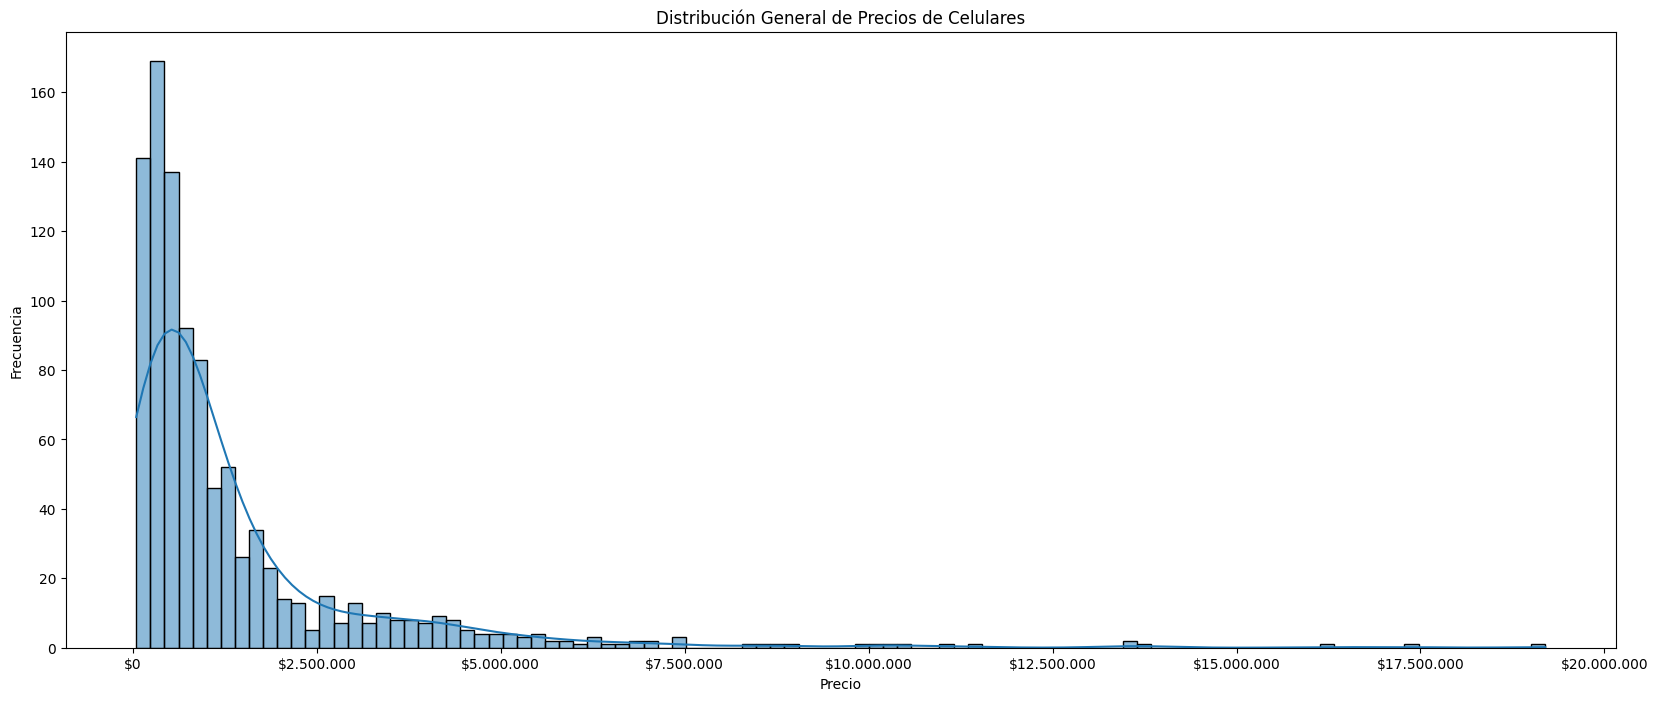

In [69]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['price'], bins=100, kde=True)
plt.title('Distribución General de Precios de Celulares')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'.replace(',', ".")))
plt.show()

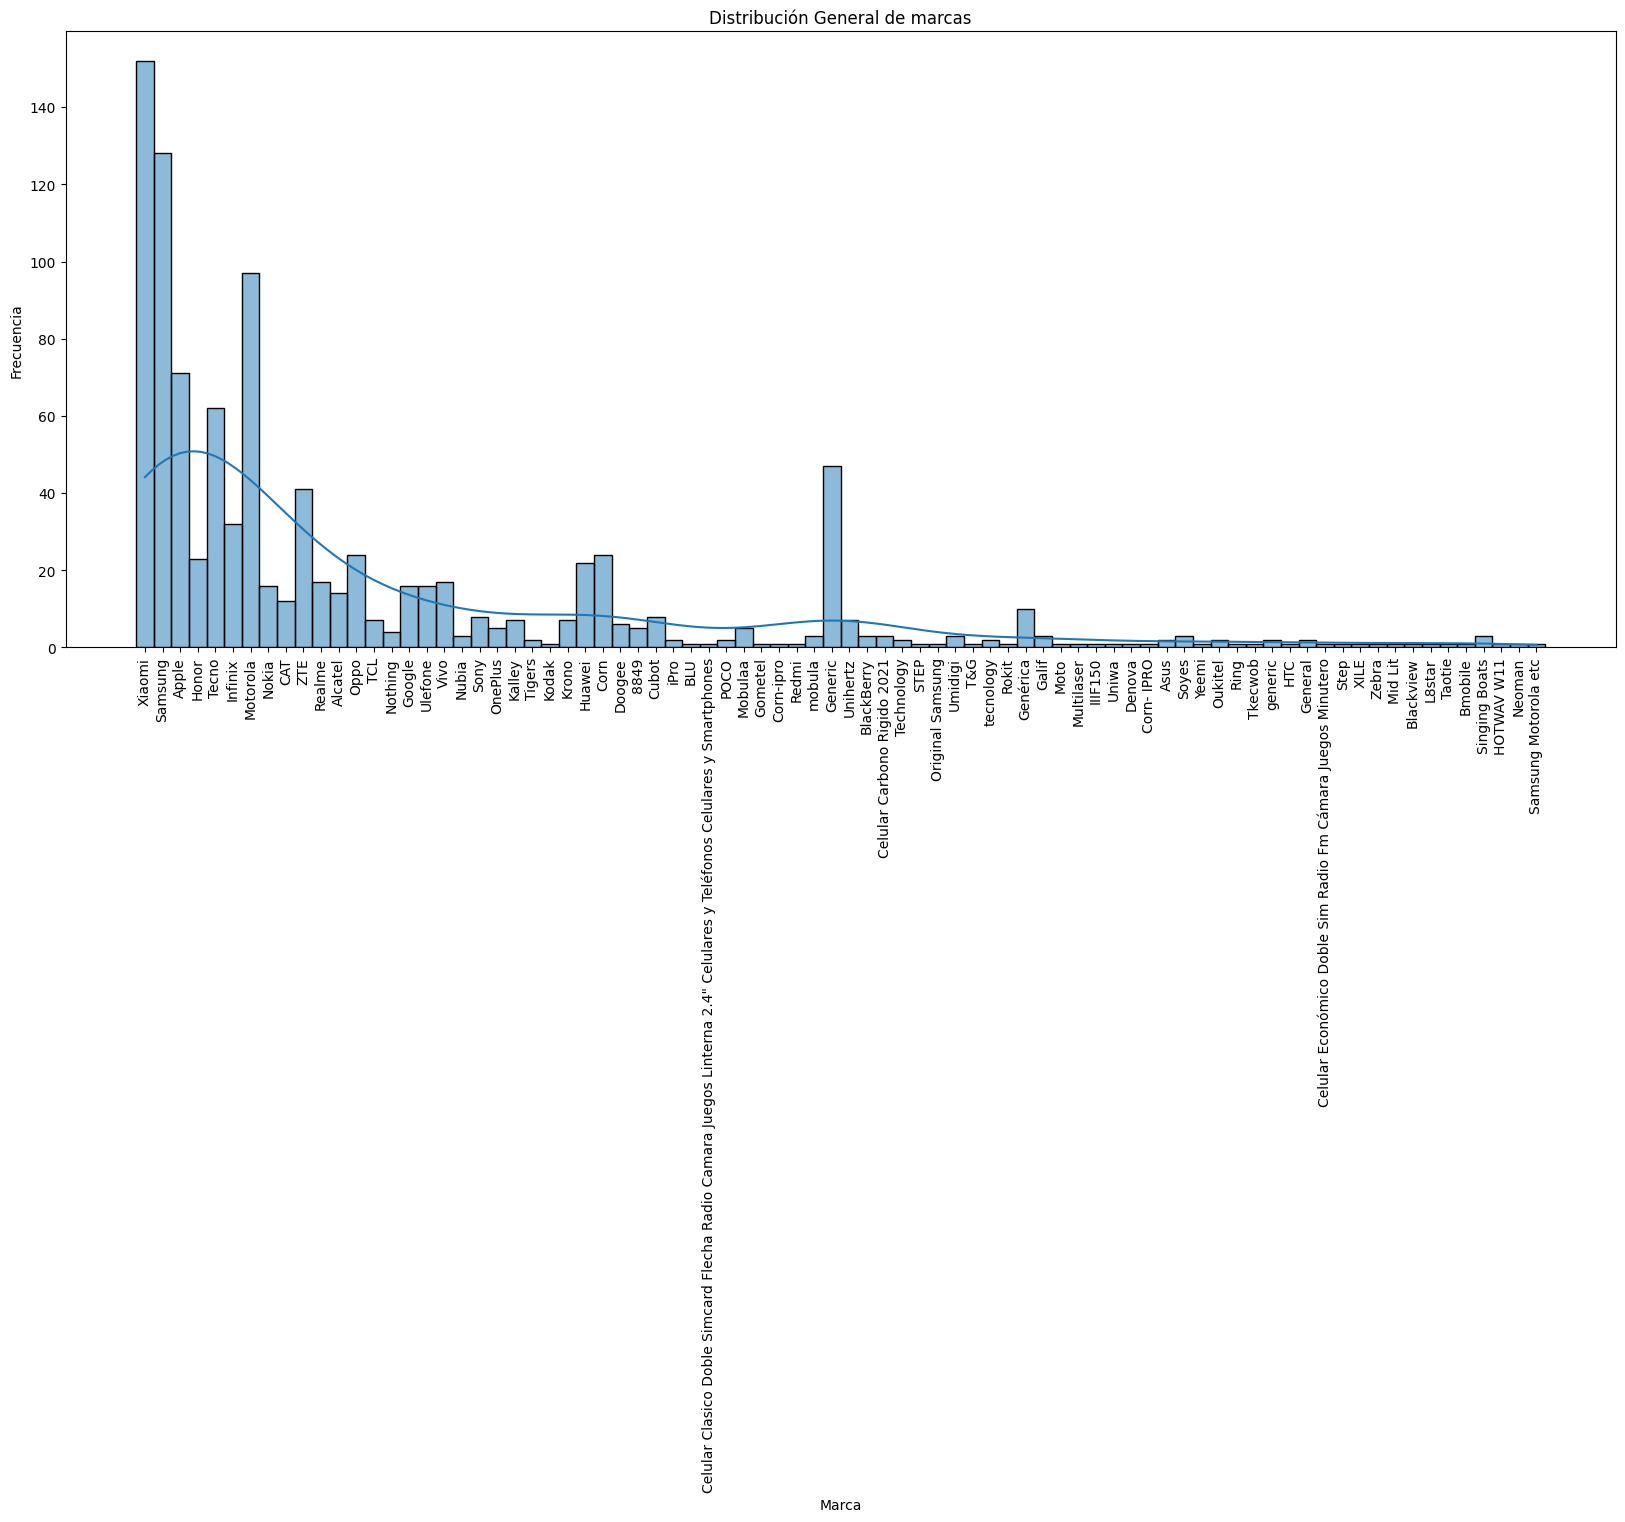

In [70]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['BRAND'], bins=100, kde=True)
plt.title('Distribución General de marcas')
plt.xlabel('Marca')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

plt.show()

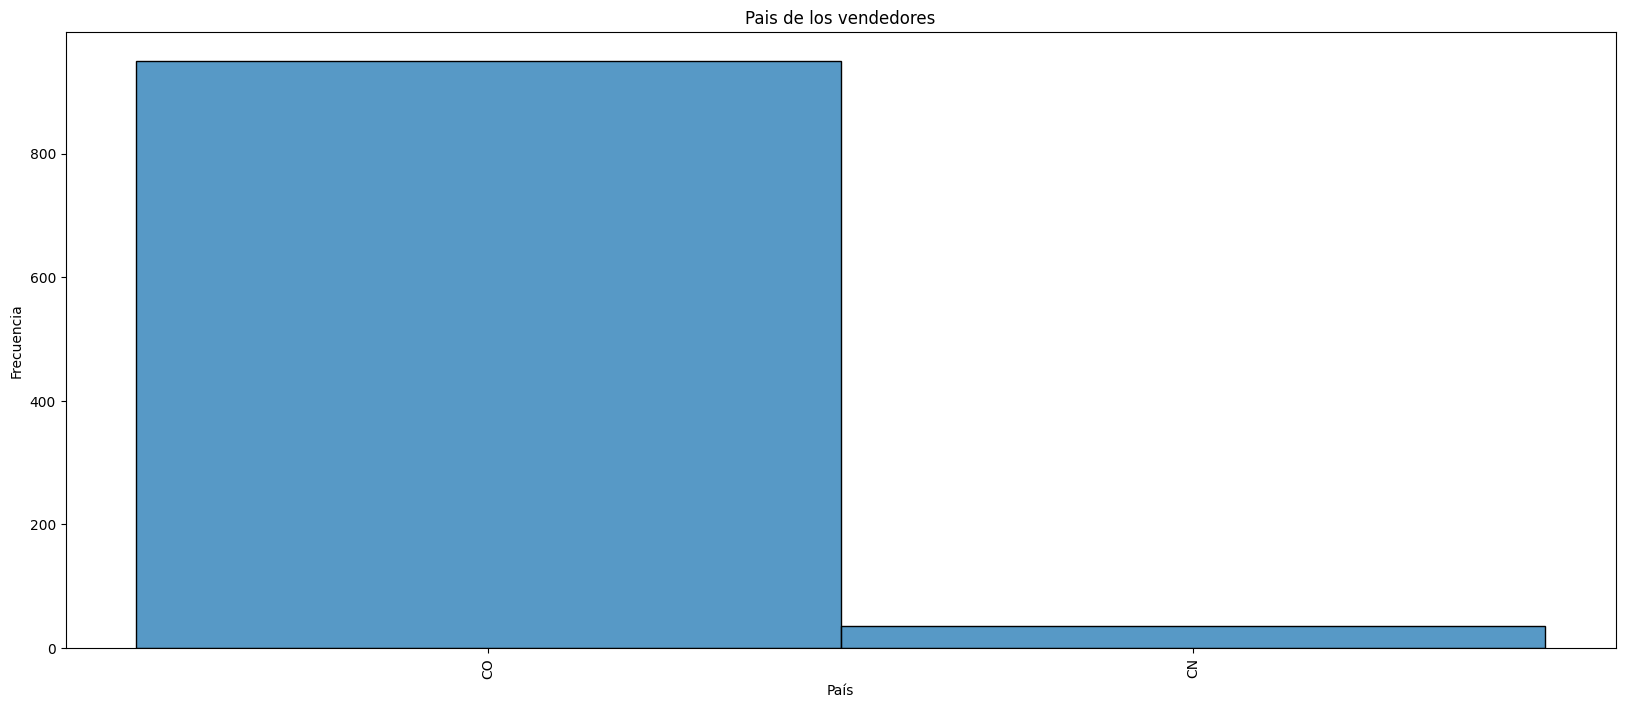

In [71]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['country_id'], bins=10)
plt.title('Pais de los vendedores')
plt.xlabel('País')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

plt.show()

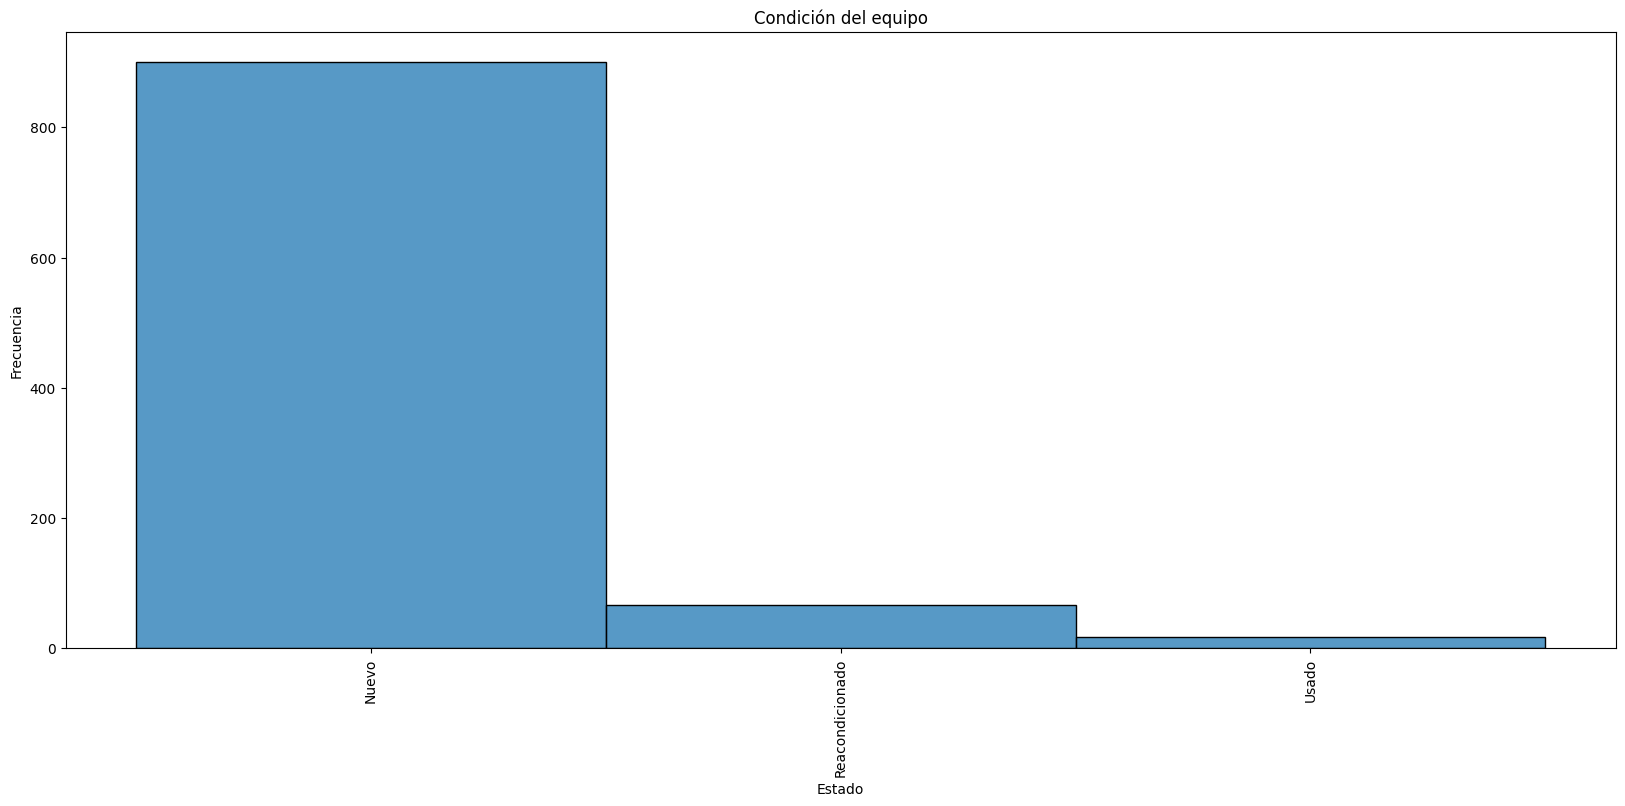

In [72]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['ITEM_CONDITION'], bins=10)
plt.title('Condición del equipo')
plt.xlabel('Estado')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

plt.show()

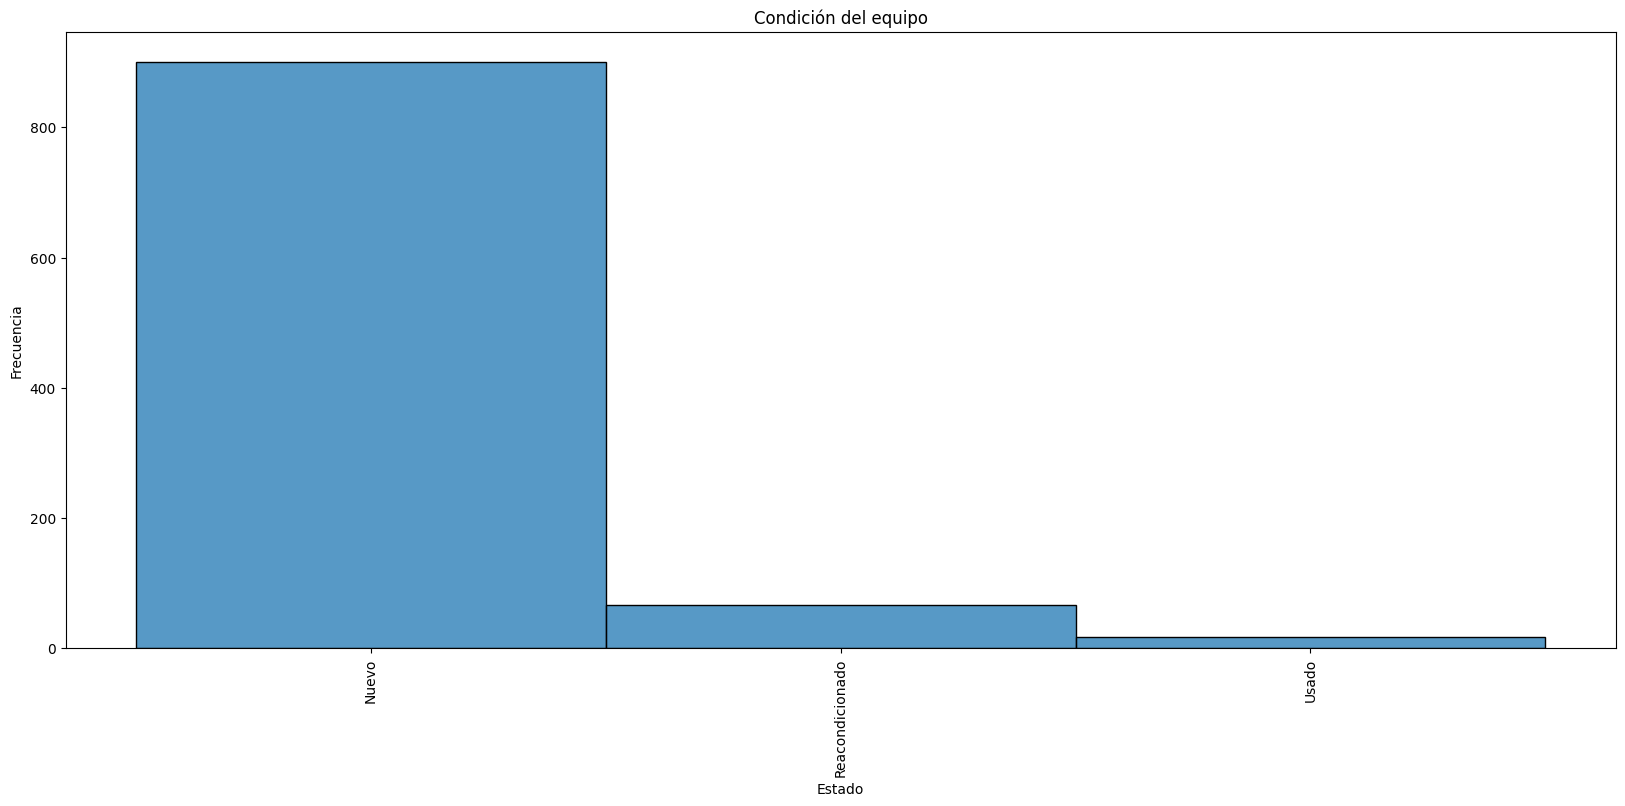

In [73]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['ITEM_CONDITION'], bins=10)
plt.title('Condición del equipo')
plt.xlabel('Estado')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

plt.show()

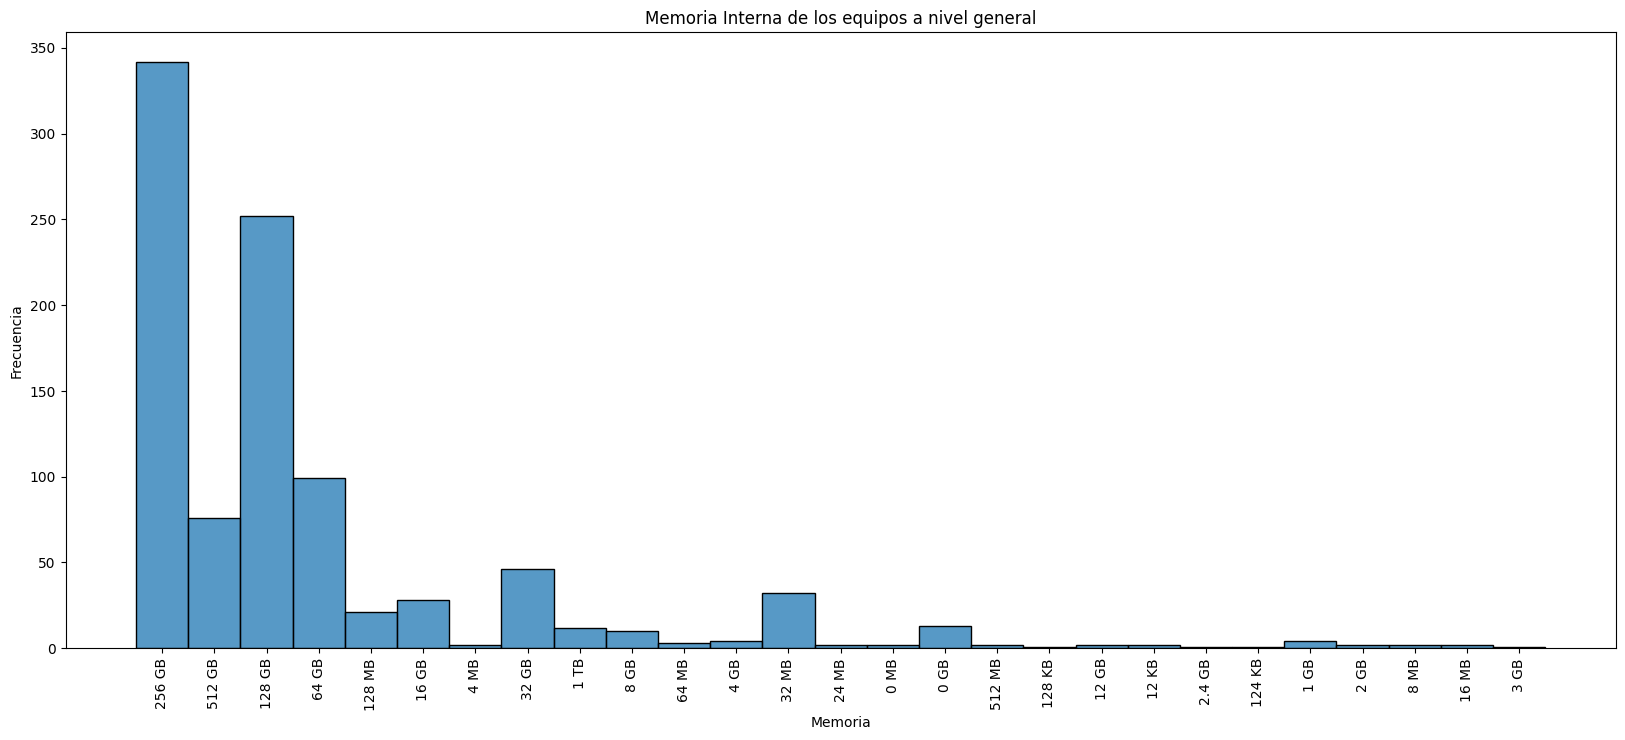

In [74]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['INTERNAL_MEMORY'], bins=10)
plt.title('Memoria Interna de los equipos a nivel general')
plt.xlabel('Memoria')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

plt.show()


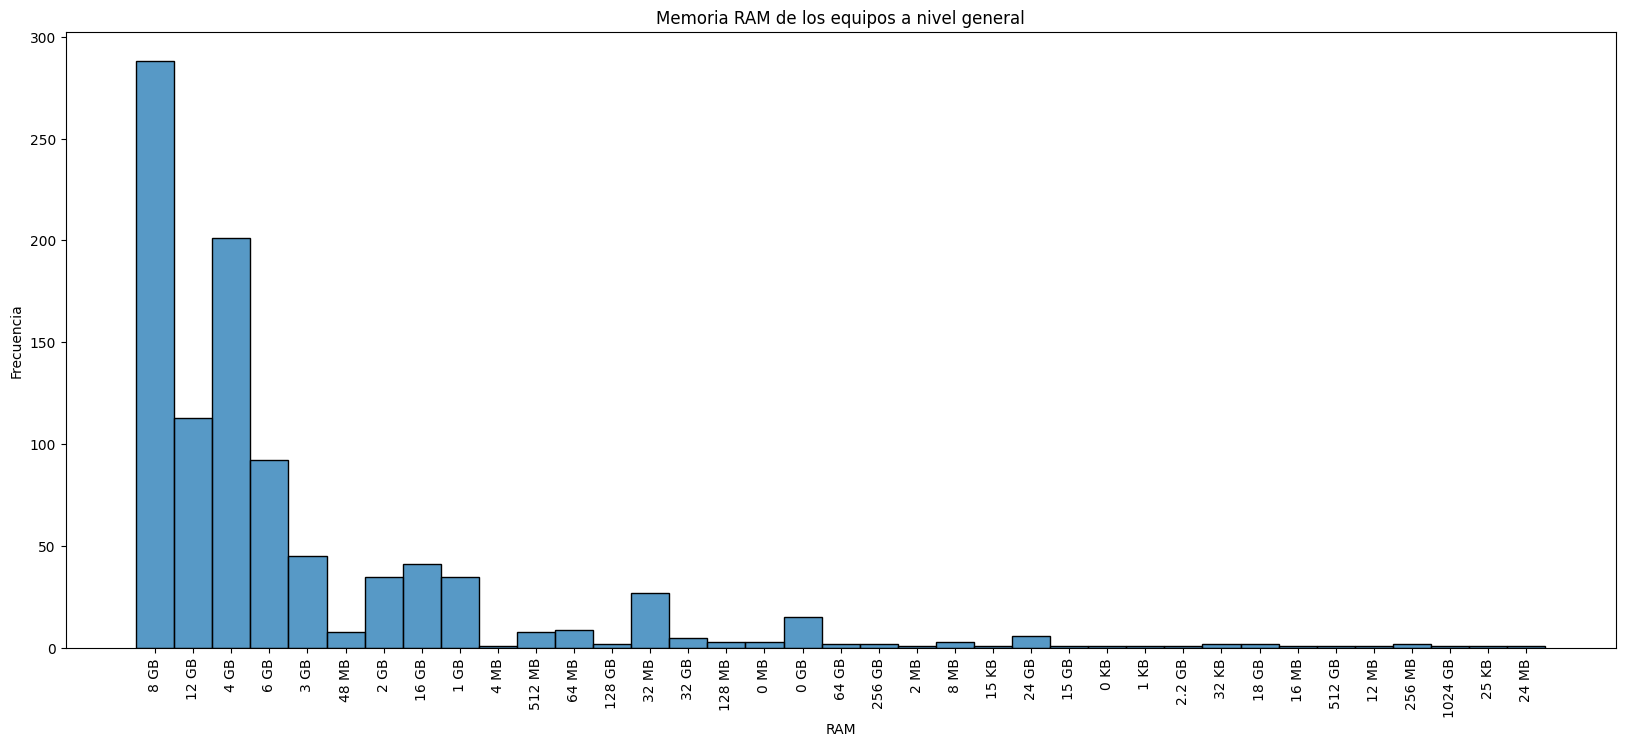

In [75]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['RAM'], bins=1)
plt.title('Memoria RAM de los equipos a nivel general')
plt.xlabel('RAM')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

plt.show()

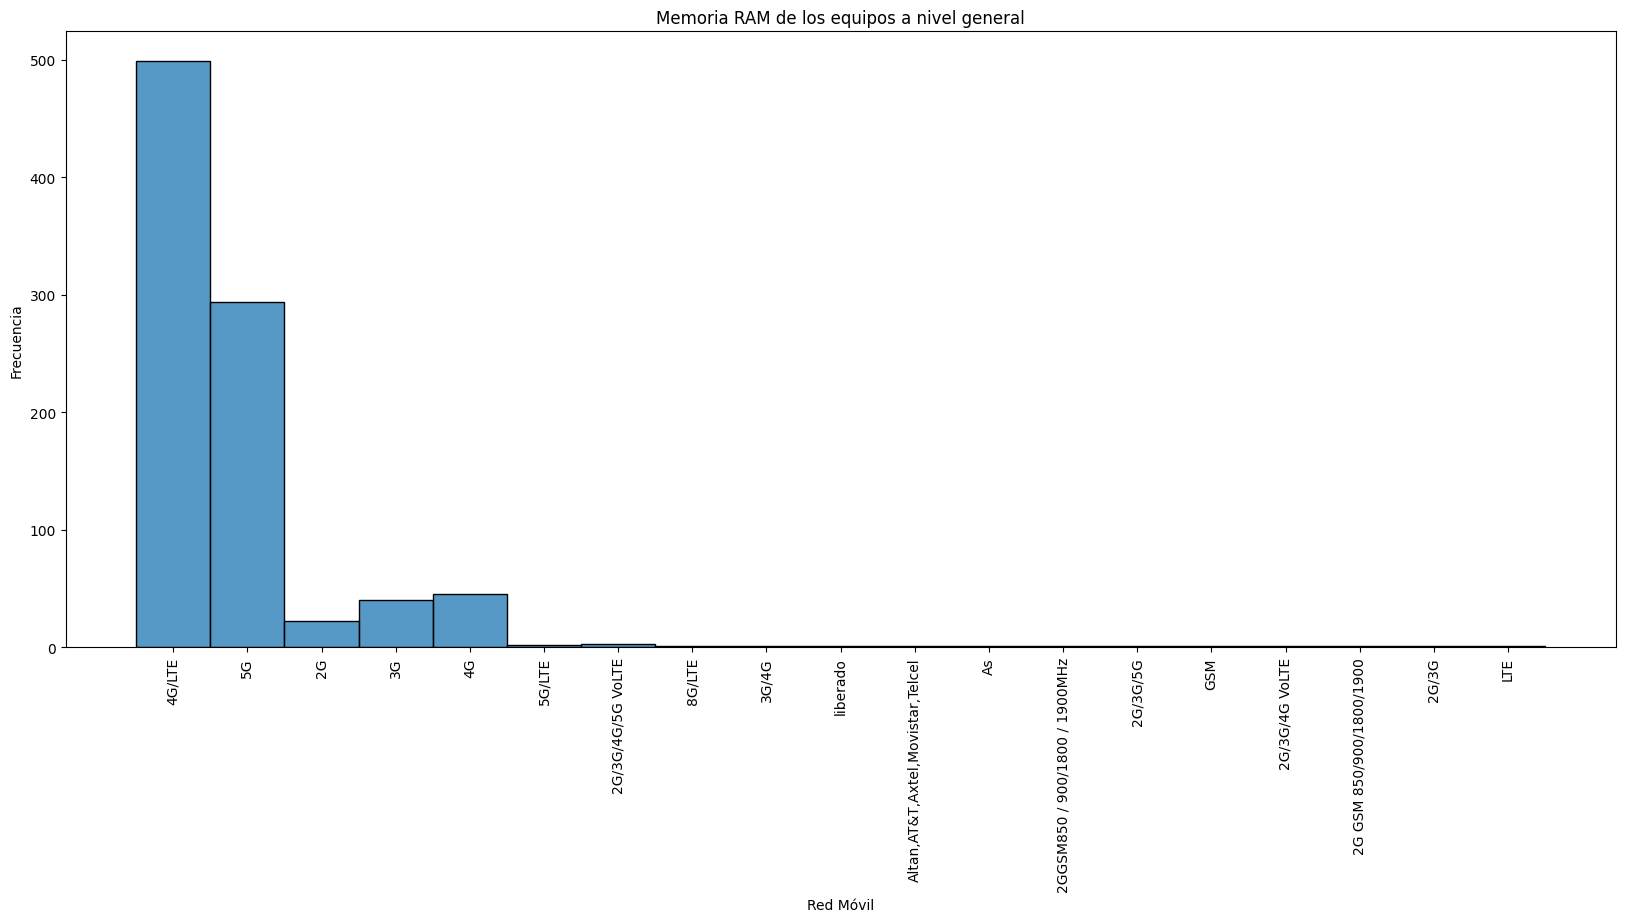

In [76]:
# Análisis univariado de precios a nivel general
plt.figure(figsize=(20, 8))
sns.histplot(completo['MOBILE_NETWORK'], bins=1)
plt.title('Memoria RAM de los equipos a nivel general')
plt.xlabel('Red Móvil')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)

plt.show()

## Analisis bivariado general
([Volver al Inicio](#Puntos)) | ([Volver al Punto 2](#Punto-2))

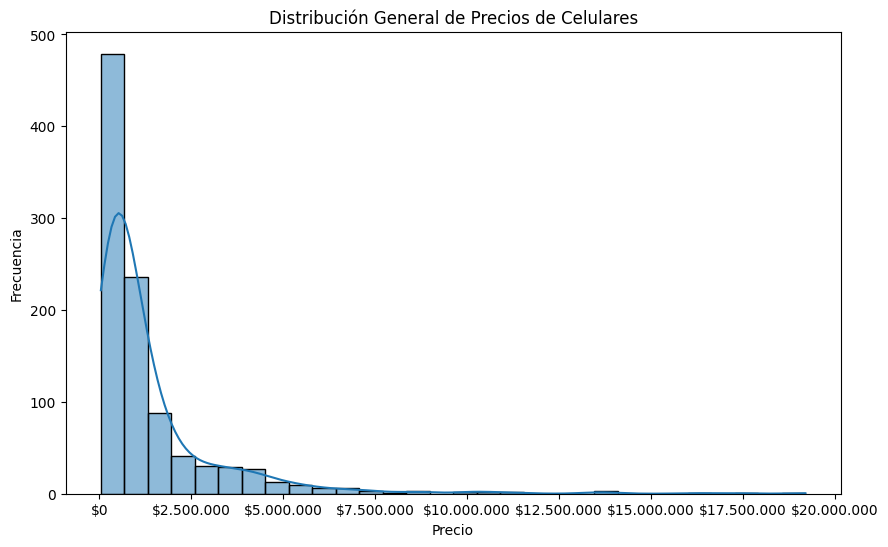

In [78]:
# Análisis univariado
plt.figure(figsize=(10, 6))
sns.histplot(completo['price'], bins=30, kde=True)
plt.title('Distribución General de Precios de Celulares')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'.replace(',', ".")))
plt.show()

### Variables interes
([Volver al Inicio](#Puntos)) | ([Volver al Punto 2](#Punto-2))

In [80]:
completo['memoria_ram_bytes'] = completo['RAM'].apply(convertir_a_bytes)
completo['memoria_interna_bytes'] = completo['INTERNAL_MEMORY'].apply(convertir_a_bytes)

In [81]:
# se realiza el filtro respectivo por las variables de interes
filtro = completo[
                    (completo['price'] <= 1200000) & # PRECIO MAXIMO A CONSIDERAR
                    (completo['ITEM_CONDITION'] == 'Nuevo') & # CONDICION DEL EQUIPO
                    (completo['country_id'] == 'CO') & # UBICACION DEL VENDEDOR
                    (completo['state'] == 'CO-DC') & # UBICACION EN BOGOTA DEL VENDEDOR
                    (completo['memoria_ram_bytes'] >= (6*1024^3))  & # MINIMO DE 6GB DE RAM
                    (completo['memoria_interna_bytes'] >= (128*1024^4)) & # MINIMO 128GB DE ALMACENAMIENTO
                    (completo['MOBILE_NETWORK'].str.contains('5G|4G|LTE', na=False)) # COMPATIBLE CON REDES DE ULTIMA GENERACION
                ]

In [82]:
# dimensiones del DF con los filtros aplicados
filtro.shape

(150, 292)

In [83]:
# FILTRO DE UN ID QUE CUMPLE CON EL FILTRO ANTERIOR
filtro[(filtro['id']=='MCO2047025726')]

,id,sanitized_title,order_backend,sale_price,available_quantity,use_thumbnail_id,shipping_x,stop_time,seller,attributes_x,installments,winner_item_id,discounts,promotions,inventory_id,differential_pricing,official_store_name,variation_filters,variations_data,seller_id,base_price,initial_quantity,sale_terms,pictures,video_id,descriptions,non_mercado_pago_payment_methods,shipping_y,international_delivery_mode,seller_address,seller_contact,location,coverage_areas,attributes_y,listing_source,variations,status_x,sub_status,tags,warranty,parent_item_id,deal_ids,automatic_relist,date_created,last_updated,health,ACCESSORIES_INCLUDED,BATTERY_CAPACITY,BRAND,CARRIER,DISPLAY_SIZE,HAZMAT_TRANSPORTABILITY,HEIGHT,INTERNAL_MEMORY,IS_DUAL_SIM,IS_GAMING_CELLPHONE,IS_RUGGED_CELLPHONE,ITEM_CONDITION,LINE,MOBILE_NETWORK,MODEL,OPERATING_SYSTEM_NAME,PROCESSOR_MODEL,PROCESSOR_SPEED,PRODUCT_LIFE,RAM,TECHNICAL_SERVICE_OR_REPLACEMENT_PARTS_PERIOD,WITH_CAMERA,WITH_FACIAL_RECOGNITION,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_RADIO,WITH_TOUCHSCREEN_DISPLAY,WITH_WIFI,ESIMS_NUMBER,SIM_CARD_SLOTS_NUMBER,TELECOMMUNICATION_HOMOLOGATION_NUMBER,CELLPHONES_ANATEL_HOMOLOGATION_NUMBER,CHARGE_CONNECTOR_TYPE,COLOR,DISPLAY_REFRESH_RATE,DISPLAY_RESOLUTION_TYPE,DISPLAY_TECHNOLOGY,GTIN,MAIN_COLOR,MAIN_REAR_CAMERA_RESOLUTION,PROCESSOR_CORES_NUMBER,WITH_3_5_MM_JACK_CONNECTOR,WITH_ACCELEROMETER,WITH_BLUETOOTH,WITH_FAST_CHARGING,WITH_FINGERPRINT_READER,WITH_FRONT_CAMERA_FLASH,WITH_MEMORY_CARD_SLOT,WITH_PROXIMITY_SENSOR,WITH_USB_CONNECTOR,SELLER_SKU,BATTERY_TYPE,COMPATIBLE_SIM_CARD_SIZES,DEPTH,DISPLAY_RESOLUTION,INCLUDES_PENCIL,IS_DROP_RESISTANT,IS_DUST_RESISTANT,IS_SPLASH_RESISTANT,IS_WATERPROOF,IS_WATER_RESISTANT,MAIN_FRONT_CAMERA_RESOLUTION,MEMORY_CARD_MAX_CAPACITY,MEMORY_CARD_TYPES,OPERATING_SYSTEM_EDITION,ORIGIN,REAR_CAMERAS_NUMBER,STANDBY_TIME,TALK_TIME,WEIGHT,WIDTH,WITH_ESIM,WITH_FOLDABLE_DISPLAY,WITH_HAND_RECOGNITION,WITH_IRIS_RECOGNITION,WITH_MINI_HDMI,WITH_NFC,WITH_REMOVABLE_BATTERY,WITH_SECONDARY_FOLDED_DISPLAY,WITH_SECONDARY_TOUCHSCREEN_DISPLAY,WITH_TV_TUNER,WITH_WIRELESS_CHARGING,CAMERAS_MAIN_FEATURES,CHARACTERISTICS_LABEL,CPU_MODELS,DISPLAY_ASPECT_RATIO,DISPLAY_PIXELS_PER_INCH,DISPLAY_TYPE,FRONT_CAMERAS_NUMBER,FRONT_CAMERA_APERTURE,FRONT_CAMERA_RECORDING_RESOLUTION,GPU_MODEL,OS_ORIGINAL_VERSION,REAR_CAMERAS_RESOLUTION,REAR_CAMERA_APERTURE,REAR_CAMERA_RECORDING_RESOLUTION,RELEASE_YEAR,WITH_GYROSCOPE,WITH_COMPASS,MAX_DISPLAY_BRIGHTNESS,OS_PERSONALIZATION_ORIGINAL_SHELL,RELEASE_MONTH,VERSIONS,WITH_BAROMETER,DIGITAL_ZOOM,IP_RATING,OPTICAL_ZOOM,OS_LAST_COMPATIBLE_VERSION,WITH_POSITIVE_IMPACT,ALBUM_NAME,ALBUM_TYPE,ARTIST_NAME,FORMAT,GENRE,PRODUCTION_COMPANY,FRONT_CAMERAS_RESOLUTION,MANUFACTURER,MPN,WITH_HEART_RATE_SENSOR,HYBRID_ZOOM,MAX_SECONDARY_DISPLAY_BRIGHTNESS,SECONDARY_DISPLAY_PIXELS_PER_INCH,SECONDARY_DISPLAY_REFRESH_RATE,SECONDARY_DISPLAY_RESOLUTION,SECONDARY_DISPLAY_SIZE,ANATEL_HOMOLOGATION_NUMBER,FRONT_CAMERAS_TYPES,GPU_SPEED,WITH_SOS_BUTTON,EMPTY_GTIN_REASON,WIDE_ANGLE_CAMERA_RESOLUTION,REAR_CAMERAS_TYPES,ADDITIONAL_INFO_REQUIRED,OS_PERSONALIZATION_LAST_COMPATIBLE_SHELL,PACKAGE_HEIGHT,PACKAGE_LENGTH,PACKAGE_WEIGHT,PACKAGE_WIDTH,PRODUCT_FEATURES,SHIPMENT_PACKING,IS_KIT,DETAILED_MODEL,BATTERY_LIFE,BEZEL_COLOR,CASE_COLOR,IS_INFANT,IS_SMARTBAND,IS_SUITABLE_FOR_APPLICATIONS,LANGUAGES,MAX_RESOLUTION,MAX_WATER_RESISTANCE_DEPTH,OS_NAMES,ROM_MEMORY,SENSORS,SMARTWATCH_CASE_MATERIAL,SMARTWATCH_COMPATIBLE_OS,SMARTWATCH_FUNCTIONS,SMARTWATCH_VERSION,WATER_AND_DUST_RESISTANCE_CLASSIFICATION,WITH_INTEGRATED_MAPS,WITH_INTERCHANGEABLE_WRISTBAND,WITH_MICROPHONE,WITH_MOBILE_NETWORK,WITH_ROTATING_BEZEL,WITH_SIM_CARD_SLOT,WITH_SOUND_REPRODUCTION,WITH_USB,WITH_VIDEO_REPRODUCTION,WRISTBAND_COLOR,WRISTBAND_DESIGN,WRISTBAND_SIZE,WRISTBAND_TYPE,WRISTBAND_WIDTH,ALPHANUMERIC_MODELS,CLOSED_DEPTH,CLOSED_HEIGHT,CLOSED_WIDTH,SECONDARY_DISPLAY_TECHNOLOGY,SECONDARY_FOLDED_DISPLAY_SIZE,ELECTRICAL_SAFETY_CERTIFICATE_NUMBER,OCP_CERTIFICATION_AGENCY,FOLDED_DISPLAY_PIXELS_PER_INCH,MANU

### Analisis bivariado
([Volver al Inicio](#Puntos)) | ([Volver al Punto 2](#Punto-2))

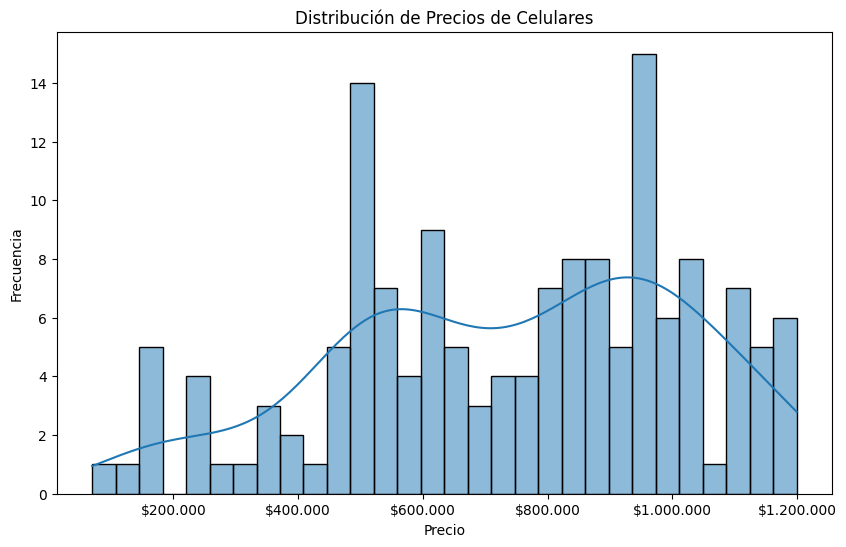

In [85]:
# Análisis univariado
plt.figure(figsize=(10, 6))
sns.histplot(filtro['price'], bins=30, kde=True)
plt.title('Distribución de Precios de Celulares')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'.replace(',', ".")))
plt.show()

Se evidencia una variacion de precios de celulares con precios inferiores al COP\\$ 1.200.000 , y una cantidad significativa de unidades entre los rangos de precios superiores a los COP\\$ 500.000 aprox al COP\\$ 1.000.000

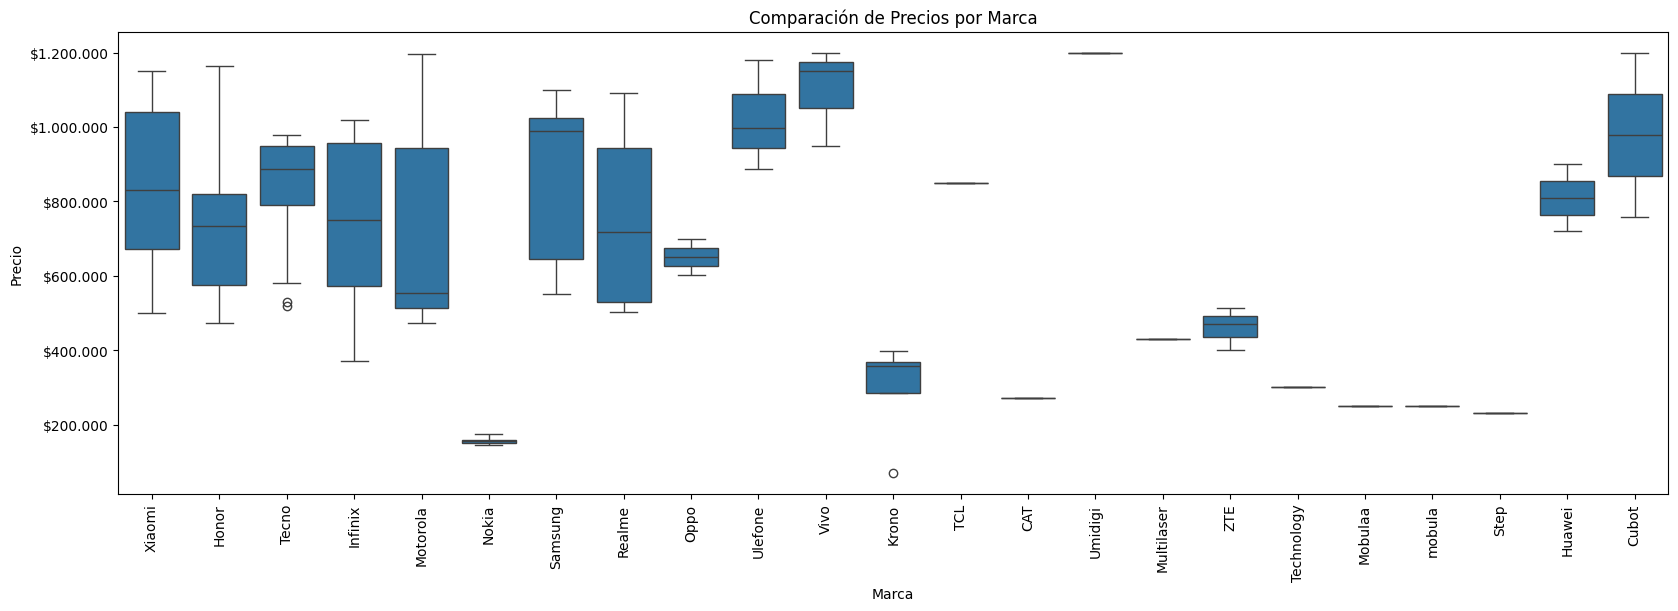

In [87]:
# Análisis bivariado
plt.figure(figsize=(20, 6))
sns.boxplot(data=filtro, x='BRAND', y='price')
plt.title('Comparación de Precios por Marca')
plt.xlabel('Marca')
plt.ylabel('Precio')
plt.xticks(rotation=90)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'.replace(',', ".")))
plt.show()

In [88]:
# Marcas
marcas = filtro['BRAND'].value_counts().sort_values(ascending=False)
marcas

BRAND
Tecno         31
Xiaomi        29
Motorola      26
Honor         10
Infinix        8
Samsung        8
Nokia          6
Krono          4
Realme         4
Vivo           3
ZTE            3
Ulefone        3
Oppo           2
mobula         2
Huawei         2
Cubot          2
TCL            1
CAT            1
Umidigi        1
Multilaser     1
Technology     1
Mobulaa        1
Step           1
Name: count, dtype: int64

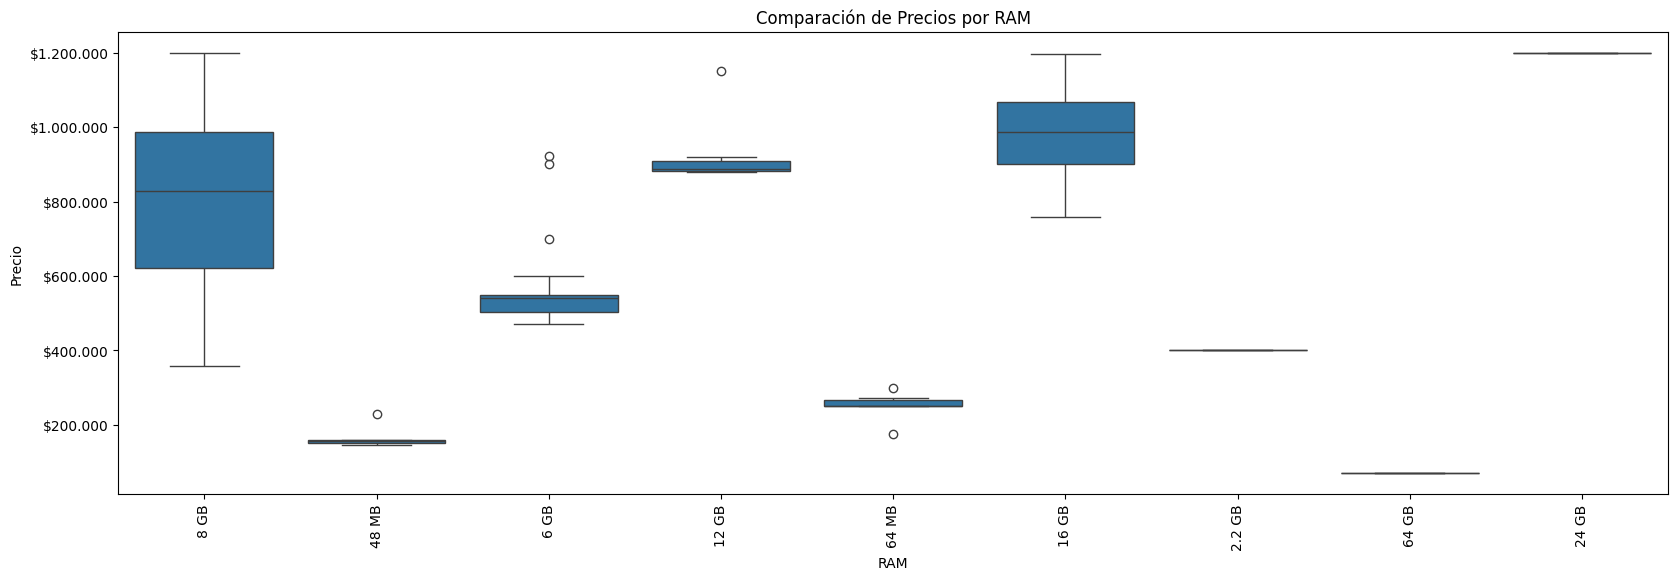

In [89]:
# Análisis bivariado
plt.figure(figsize=(20, 6))
sns.boxplot(data=filtro, x='RAM', y='price')
plt.title('Comparación de Precios por RAM')
plt.xlabel('RAM')
plt.ylabel('Precio')
plt.xticks(rotation=90)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'.replace(',', ".")))
plt.show()

El anterior boxplot, evidencia que varios de los datos se encuentran distribuidos por memoria RAM de 8 GB y sus rangos de precios se concentran más entre los 600.000 y el 1.000.000

In [91]:
# Marcas
conteo_ram = filtro.groupby('RAM')['memoria_ram_bytes'].count().reset_index()
conteo_ram.rename(columns={'memoria_ram_bytes': 'Cantidad'}, inplace=True)
conteo_ram_ordenado = conteo_ram.sort_values(by='Cantidad', ascending=False)
conteo_ram_ordenado

,RAM,Cantidad
8,8 GB,104
5,6 GB,17
0,12 GB,10
4,48 MB,6
7,64 MB,6
1,16 GB,4
2,2.2 GB,1
3,24 GB,1
6,64 GB,1


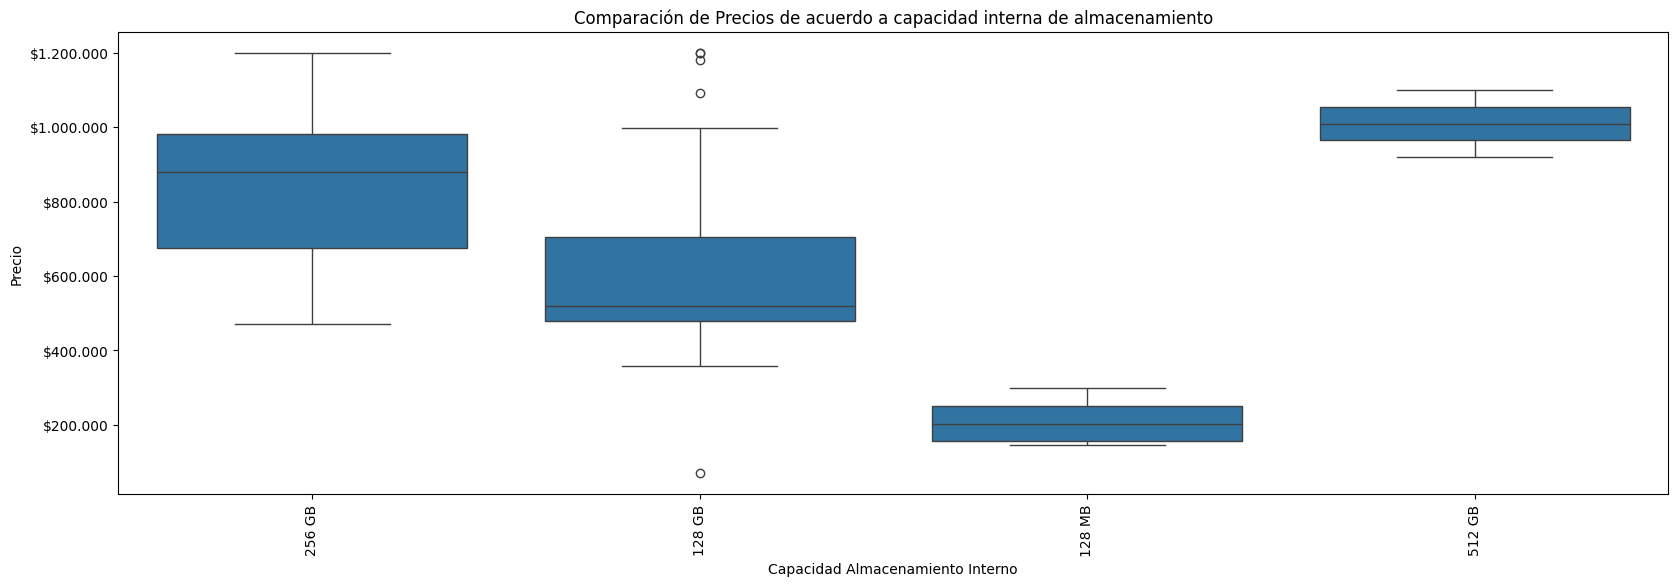

In [92]:
# Análisis bivariado
plt.figure(figsize=(20, 6))
sns.boxplot(data=filtro, x='INTERNAL_MEMORY', y='price')
plt.title('Comparación de Precios de acuerdo a capacidad interna de almacenamiento')
plt.xlabel('Capacidad Almacenamiento Interno')
plt.ylabel('Precio')
plt.xticks(rotation=90)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'.replace(',', ".")))
plt.show()

In [93]:
# Marcas
conteo_ram = filtro.groupby('INTERNAL_MEMORY')['memoria_interna_bytes'].count().reset_index()
conteo_ram.rename(columns={'memoria_interna_bytes': 'Cantidad'}, inplace=True)
conteo_ram_ordenado = conteo_ram.sort_values(by='Cantidad', ascending=False)
conteo_ram_ordenado

,INTERNAL_MEMORY,Cantidad
2,256 GB,100
0,128 GB,36
1,128 MB,12
3,512 GB,2


## Punto 3
([Volver al inicio](#Puntos))

### Punto 3.1
([Volver al inicio](#Puntos)) | ([Volver al Punto 3](#Punto-3))

La estrategia de selección para el regalo de mamá implica:
- Definición de criterios: características que se alineen con las necesidades y preferencias de mamá. 
- Filtrado inicial: Aplicar filtros es un método efectivo para reducir el volumen de opciones, facilitando la toma de decisiones. Al centrarse en las condiciones deseadas, se ahorra tiempo.
- Análisis de características: Evaluar las opciones restantes permite hacer una elección informada. Asegura que el celular no solo se ajuste al presupuesto, sino que también ofrezca las funcionalidades necesarias.
- Recomendación final: Elegir el celular con la mejor relación de calidad-precio es clave para asegurar satisfacción a largo plazo.

### Punto 3.2
([Volver al Inicio](#Puntos)) | ([Volver al Punto 3](#Punto-3))

En el punto 2, se evidencian marcas de equipos reconocidas en el mercado, lo cual sugiere una buena selección entre las mismas.<br/>
Se realiza una prueba ANOVA para comparar los precios entre marcas, donde ayuda a revisar si las diferencias de precios son significativas.

In [99]:
# Filtrar por marcas populares o específicas
popular_brands = ['Samsung', 'Xiaomi', 'Huawei','Motorola']
selected_items = filtro[filtro['BRAND'].isin(popular_brands)]

# Prueba estadística (ANOVA para comparar precios entre marcas)
from scipy import stats

anova_results = stats.f_oneway(
    selected_items[selected_items['BRAND'] == 'Samsung']['price'],
    selected_items[selected_items['BRAND'] == 'Xiaomi']['price'],
    selected_items[selected_items['BRAND'] == 'Huawei']['price'],
    selected_items[selected_items['BRAND'] == 'Motorola']['price']
)


In [100]:
# Resultados ANOVA
anova_results

F_onewayResult(statistic=2.1443528737727235, pvalue=0.10383806650708041)

La falta de significancia estadística sugiere que, en promedio, los precios de las diferentes marcas no difieren de manera significativa. Esto puede ser un hallazgo importante, ya que indica que no se debe basar la elección del celular únicamente en la marca en términos de precios, ya que el costo podría no reflejar diferencias significativas en calidad o características.

Aunque no se encontró una diferencia significativa en los precios, esto no significa que todas las marcas ofrezcan el mismo valor o calidad. Otros factores, como la reputación del vendedor, características técnicas y la experiencia de usuario, deben ser considerados en el proceso de selección.

In [102]:
# Prueba estadística (t-test), con solo dos más reconocidas
from scipy.stats import ttest_ind

marca_1 = selected_items[selected_items['BRAND'] == 'Samsung']['price']
marca_2 = selected_items[selected_items['BRAND'] == 'Motorola']['price']

stat, p = ttest_ind(marca_1, marca_2)

In [103]:
print(f'Statistic: {stat}, p-value: {p}')

Statistic: 1.6781460947825018, p-value: 0.10306036150653401


El resultado del t-test, demuestra que aunque hay una diferencia en los precios entre las dos marcas, esta diferencia no es estadísticamente significativa.

### Punto 3.3
([Volver al Inicio](#Puntos)) | ([Volver al Punto 3](#Punto-3))

In [106]:
# Seleccionar el celular con el mejor precio
recommended_phone = selected_items.loc[selected_items['price'].idxmin()]
recommended_phone[['BRAND', 'MODEL','RAM','INTERNAL_MEMORY', 'price', 'nickname']]

BRAND                        Motorola
MODEL              G24 Power Dual SIM
RAM                              8 GB
INTERNAL_MEMORY                256 GB
price                       473900.00
nickname             CAMISETASDELA 18
Name: 61, dtype: object

Este enfoque de selección se basa en la premisa de que el celular con el precio más bajo dentro de las opciones filtradas es el más atractivo desde el punto de vista económico, cumpliendo así con el objetivo de maximizar el valor de la compra para mamá.


De acuerdo con lo anterior, el celulcar seleccionado para Mamá con las caracteristicas definidas es el:
Motorola G24, con 8GB de RAM y 256 GB de almacenamiento, por el precio de COP$ 473900